## 데이터 로드 및 필요 패키지 import ##

In [1]:
import pandas as pd
import seaborn as sns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [2]:
df_trans = pd.read_csv('trans.csv')
df_whos = pd.read_csv('whoscored.csv')

In [3]:
df_trans.head()

,name,position,age,nation,team,value,matches,goals,owngoals,assists,yellowcard,second yellow card,redcard,substitutions in,substitutions out
0,kim min-jae,DF,26,"Korea, South",SSC Napoli,750.0,47,2,0,2,8,0,0,1,4
1,takehiro tomiyasu,DF,24,Japan,Arsenal FC,375.0,32,0,0,2,2,0,0,18,9
2,harry souttar,DF,24,Australia,Leicester City,225.0,22,0,1,2,6,0,0,1,3
3,ko itakura,DF,26,Japan,Borussia Mönchengladbach,180.0,25,0,0,2,1,0,2,2,0
4,hiroki ito,DF,24,Japan,VfB Stuttgart,112.5,35,1,0,2,6,0,0,1,2


In [4]:
df_whos.head()

,name,team,league,age,position,match,min,tackle,intercept,foul,...,keyP,Drb,fouled,avgP,PS,cross,longP,ThrP,mom,rating
0,asmir begovic,Everton,England,35,GK,1,90,0.0,0.0,0.0,...,0.0,0.0,0.0,25.0,64.0,0.0,5.0,0.0,1,7.82
1,kevin de bruyne,Man City,England,31,"M(CLR),FW",27,2356,0.9,0.3,0.7,...,3.2,1.1,0.9,44.1,80.6,2.1,2.6,0.5,9,7.67
2,erling haaland,Man City,England,22,FW,32,2673,0.1,0.1,0.9,...,0.8,0.3,0.7,13.9,75.3,0.0,0.1,0.1,6,7.60
3,harry kane,Tottenham,England,29,"AM(C),FW",36,3228,0.4,0.1,0.8,...,1.5,1.1,1.6,21.8,71.8,0.2,1.9,0.3,7,7.47
4,kieran trippier,Newcastle,England,32,"D(LR),M(R)",36,3168,1.9,1.2,1.2,...,3.0,0.5,0.8,52.8,75.1,3.6,3.6,0.2,8,7.45


In [25]:
##후스코어드 데이터의 포지션 변수가 일관적이지 않음
df_whos['position'] = df_whos['position'].str.replace('M\(.*\)', 'MF', regex = True)
df_whos['position'] = df_whos['position'].str.replace('D\(.*\)', 'DF', regex = True)
df_whos['position'] = df_whos['position'].str.replace('Forward', 'FW')
df_whos['position'] = df_whos['position'].str.replace('Midfielder', 'MF')
df_whos['position'] = df_whos['position'].str.replace('Defender', 'DF')
df_whos['position'] = df_whos['position'].str.replace('Goalkeeper', 'GK')
df_whos['position'] = df_whos['position'].str.replace(' DF,FW  ', 'DF')
df_whos['position'] = df_whos['position'].str.replace(' DMC,MF  ', 'MF')
df_whos['position'] = df_whos['position'].str.replace(' DF,MF,FW  ', 'DF,MF')
df_whos['position'] = df_whos['position'].str.replace(' DF  ', 'DF')
df_whos['position'] = df_whos['position'].str.replace(' DF,DMC,MF  ', 'DF,MF')
df_whos['position'] = df_whos['position'].str.replace(' DMC  ', 'MF')
df_whos['position'] = df_whos['position'].str.replace(' DF,DMC  ', 'DF,MF')
df_whos['position'] = df_whos['position'].str.replace(' AMF  ', 'MF,FW')
df_whos['position'] = df_whos['position'].str.replace(' MF  ', 'MF')
df_whos['position'] = df_whos['position'].str.replace(' DF,MF  ', 'DF,MF')
df_whos['position'] = df_whos['position'].str.replace(' AMF,FW  ', 'AMF,FW')
df_whos['position'] = df_whos['position'].str.replace(' FW  ', 'FW')
df_whos['position'] = df_whos['position'].str.replace(' MF,FW  ', 'AMF,FW')
df_whos['position'] = df_whos['position'].str.replace(' GK  ', 'GK')

## 각종 변수들 간의 관계 분석 ##

In [6]:
df_whos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10861 entries, 0 to 10860
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       10861 non-null  object 
 1   team       10861 non-null  object 
 2   league     10861 non-null  object 
 3   age        10861 non-null  int64  
 4   position   10861 non-null  object 
 5   match      10861 non-null  int64  
 6   min        10861 non-null  int64  
 7   tackle     10861 non-null  float64
 8   intercept  10861 non-null  float64
 9   foul       10861 non-null  float64
 10  clear      10861 non-null  float64
 11  block      10861 non-null  float64
 12  goal       10861 non-null  int64  
 13  assist     10861 non-null  int64  
 14  SPG        10861 non-null  float64
 15  keyP       10861 non-null  float64
 16  Drb        10861 non-null  float64
 17  fouled     10861 non-null  float64
 18  avgP       10861 non-null  float64
 19  PS         10861 non-null  float64
 20  cross 

**포지션, 리그에 따른 평균 비교**
- ex) 어느 포지션이 가장 골을 잘 넣을까?

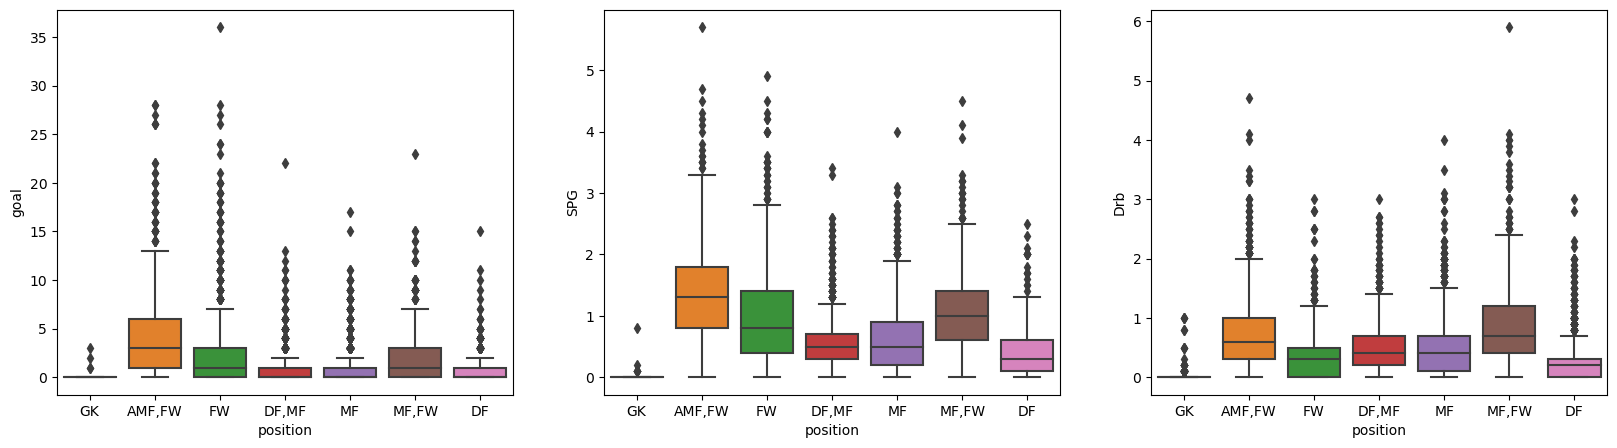

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20,5))
sns.boxplot(x='position', y='goal', data=df_whos, ax = axes[0])
sns.boxplot(x='position', y='SPG', data=df_whos, ax = axes[1])
sns.boxplot(x='position', y='Drb', data=df_whos, ax = axes[2])
plt.show()
# 공격적인 수치들은 확실히 1, 2선(공격수, 윙어, 공격형 미드필더)들의 평균이 높음

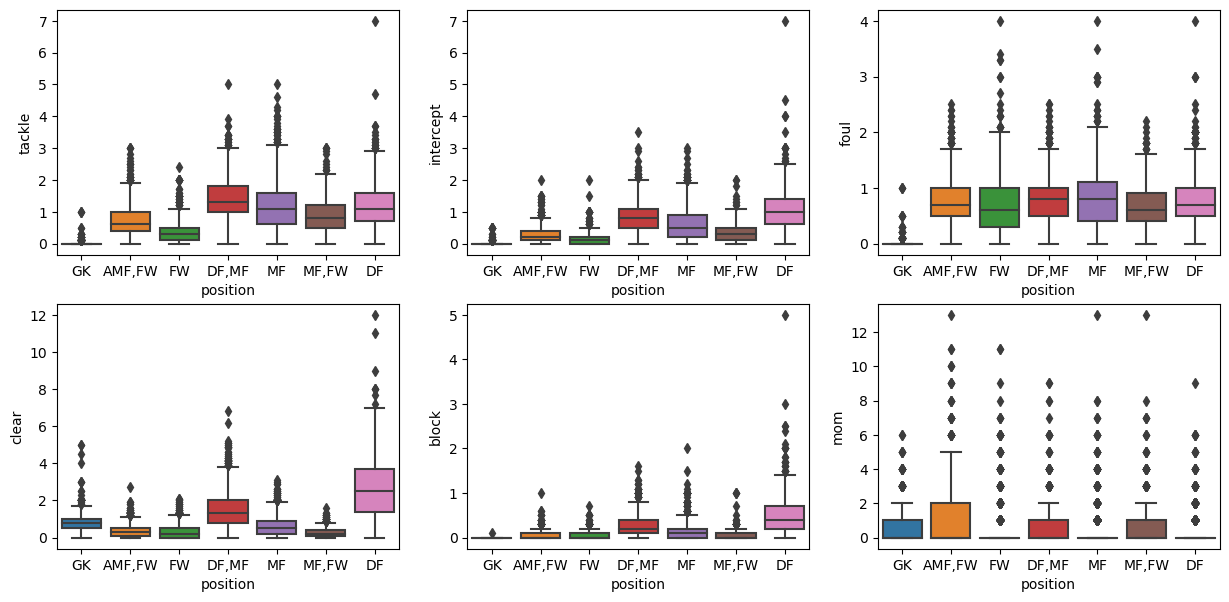

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15,7))
sns.boxplot(x='position', y='tackle', data=df_whos, ax = axes[0, 0])
sns.boxplot(x='position', y='intercept', data=df_whos, ax = axes[0, 1])
sns.boxplot(x='position', y='foul', data=df_whos, ax = axes[0, 2])
sns.boxplot(x='position', y='clear', data=df_whos, ax = axes[1, 0])
sns.boxplot(x='position', y='block', data=df_whos, ax = axes[1, 1])
sns.boxplot(x='position', y='mom', data=df_whos, ax = axes[1, 2])
plt.show()
# 수비적인 수치들은 3, 4선(중앙, 수비형 미드필더, 수비수)들의 평균이 높음
# 파울은 예외적으로 골키퍼를 제외한 모든 포지션에서 비슷함(상대 수비수 압박, 역습을 파울로 끊기 등의 행동)
# mom 수상 횟수는 골키퍼 1, 2선 및 윙백 선수들의 수치가 높음

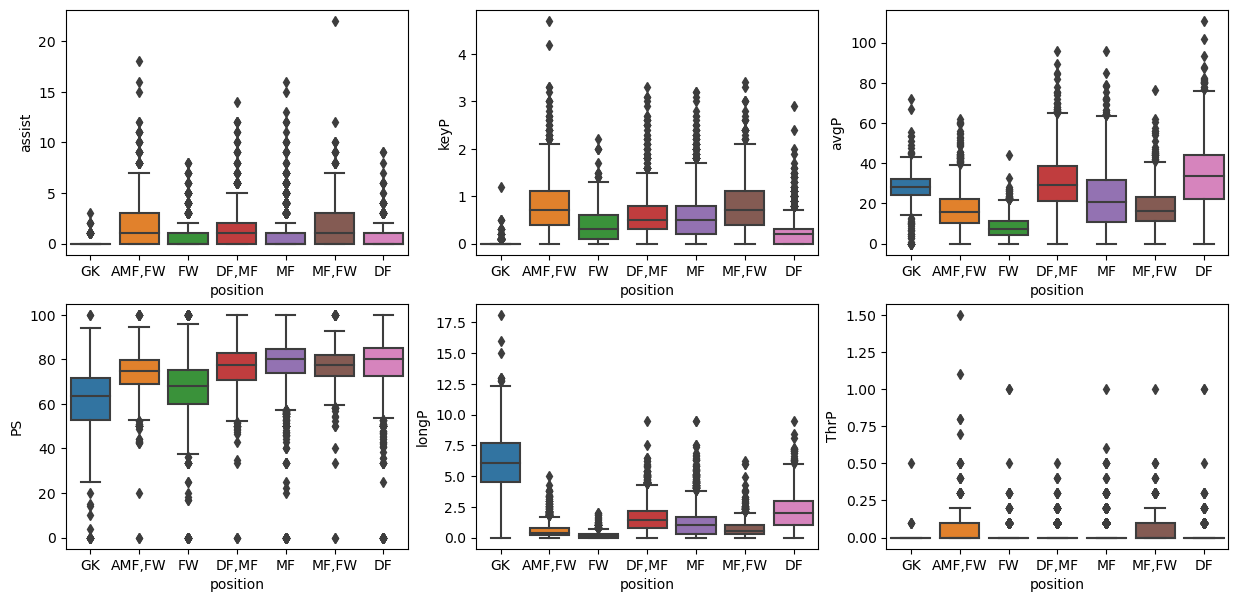

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(15,7))
sns.boxplot(x='position', y='assist', data=df_whos, ax = axes[0, 0])
sns.boxplot(x='position', y='keyP', data=df_whos, ax = axes[0, 1])
sns.boxplot(x='position', y='avgP', data=df_whos, ax = axes[0, 2])
sns.boxplot(x='position', y='PS', data=df_whos, ax = axes[1, 0])
sns.boxplot(x='position', y='longP', data=df_whos, ax = axes[1, 1])
sns.boxplot(x='position', y='ThrP', data=df_whos, ax = axes[1, 2])
plt.show()
# 패스에 관련된 수치들은 1, 2선들의 평균이 높은 모습
# 골키퍼는 골킥을 차기 때문에 롱패스 비율 높음

<Axes: xlabel='league', ylabel='assist'>

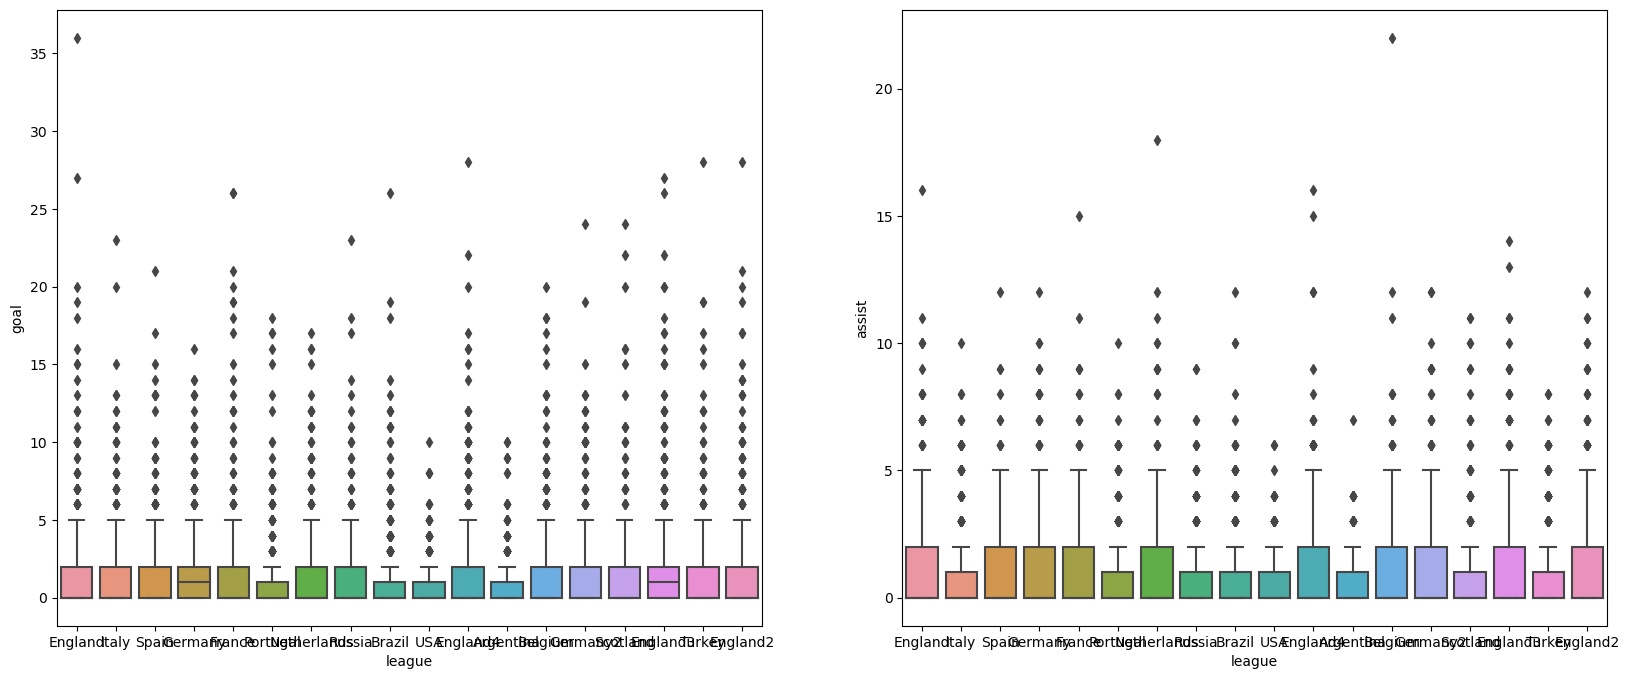

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(20,8))
sns.boxplot(x='league', y='goal', data=df_whos, ax = axes[0])
sns.boxplot(x='league', y='assist', data=df_whos, ax = axes[1])
# 리그 마다의 수준이 다를 뿐 수치에 영향을 주지는 않는 것으로 보임

- 그럼 과연 포지션과 리그는 타겟 변수인 rating과의 통계적 유의성이 있을까?

In [10]:
model=ols('rating~league', df_whos).fit()
print (anova_lm(model))
model1=ols('rating~position', df_whos).fit()
print (anova_lm(model1))

# 통계적 유의성이 있는 수준이라고 나옴
# 하지만 한 사이트에서 일정한 기준을 정하고 매긴 평점
# 리그와 포지션에 따른 통계적 유의성은 우연이라고 판단
# 라벨링하지 않음

               df       sum_sq   mean_sq         F    PR(>F)
league       17.0     4.200134  0.247067  2.214408  0.002783
Residual  10843.0  1209.778866  0.111572       NaN       NaN
               df       sum_sq    mean_sq           F         PR(>F)
position      6.0    76.903553  12.817259  122.347667  3.377195e-150
Residual  10854.0  1137.075447   0.104761         NaN            NaN


**변수 끼리의 상관 분석**
- ex) 슛을 많이 때리는 선수는 골을 많이 넣을까?
- 주요 변수들 과의 상관관계 분석
- 여러가지 기본 상식과 현대 축구의 양상

PearsonRResult(statistic=0.2313456822169458, pvalue=6.517570348625156e-132)

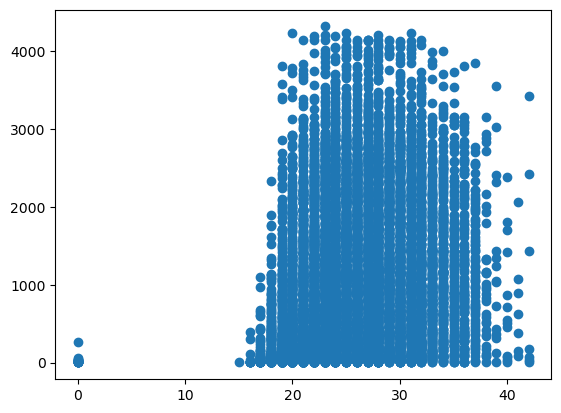

In [11]:
plt.scatter("age", "min", data=df_whos)
stats.pearsonr(df_whos['age'], df_whos['min'])
# 젊은 선수들은 더 많은 시간을 뛰었을까? -> 어느 정도의 상관관계가 있음, 20 ~ 30 초반 나이(전성기)의 선수들이 출전시간이 많은 모습

PearsonRResult(statistic=0.48642586347877625, pvalue=0.0)

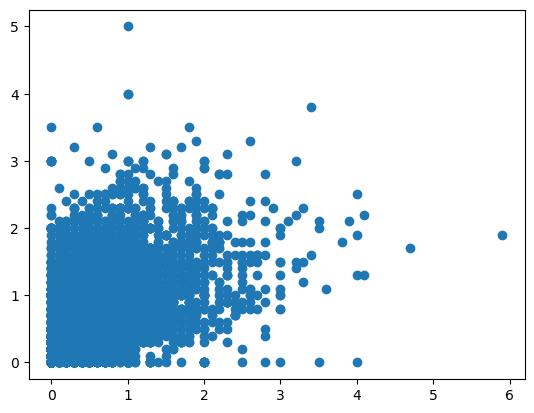

In [12]:
plt.scatter("Drb", "fouled", data=df_whos)
stats.pearsonr(df_whos['Drb'], df_whos['fouled'])
# 드리블을 많이 하는 선수들은 파울을 많이 당하는 모습

1. SPG & Goal:  PearsonRResult(statistic=0.6960409307120601, pvalue=0.0)
2. assist & Goal :  PearsonRResult(statistic=0.5207701847949229, pvalue=0.0)
3. Drb & Goal :  PearsonRResult(statistic=0.28669589157450215, pvalue=1.5162350924217942e-204)
4. MOM & Goal :  PearsonRResult(statistic=0.648603089088813, pvalue=0.0)


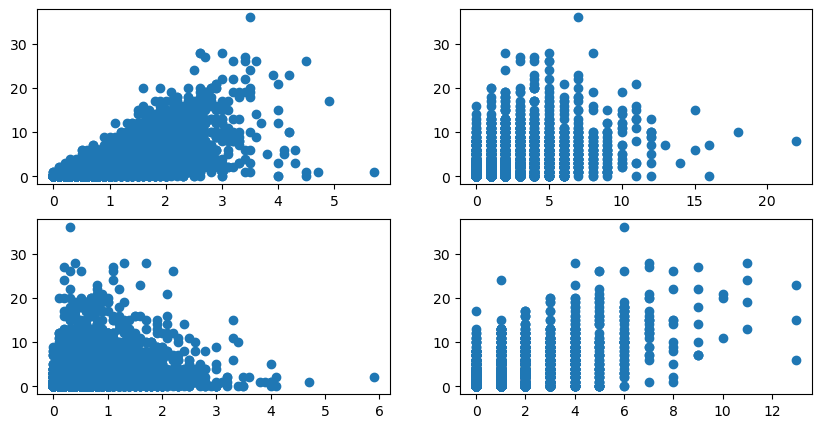

In [169]:
# 골과 관련된 변수들의 상관 관계 관찰

fig, axes = plt.subplots(2, 2, figsize=(10,5))
axes[0, 0].scatter("SPG", "goal", data=df_whos)
axes[0, 1].scatter("assist", "goal", data=df_whos)
axes[1, 0].scatter("Drb", "goal", data=df_whos)
axes[1, 1].scatter("mom", "goal", data=df_whos)

print("1. SPG & Goal: ", stats.pearsonr(df_whos['SPG'], df_whos['goal']))
print("2. assist & Goal : ", stats.pearsonr(df_whos['assist'], df_whos['goal']))
print("3. Drb & Goal : ", stats.pearsonr(df_whos['Drb'], df_whos['goal']))
print("4. MOM & Goal : ", stats.pearsonr(df_whos['mom'], df_whos['goal']))

# 모든 변수가 유의한 상관계수를 가짐
# 하지만 시각화만 보았을 때 드리블 시도를 많이 하는 선수가 골을 많이 넣지는 않아 보이는 모습
# 골과 어시스트는 상관관계가 높지 않을거라 생각했지만 높은 상관관계를 보임
# 골을 많이 넣은 선수가 Man of the Match에 많이 선정되는 모습

1. keyP & assist:  PearsonRResult(statistic=0.6538976305427376, pvalue=0.0)
2. avgP & assist :  PearsonRResult(statistic=0.18431595960793223, pvalue=1.3124624454059069e-83)
3. PS & assist :  PearsonRResult(statistic=0.07037805306918346, pvalue=2.0918797118060147e-13)
4. cross & assist :  PearsonRResult(statistic=0.47654046240361014, pvalue=0.0)
5. longP & assist :  PearsonRResult(statistic=-0.04688125330150035, pvalue=1.0191337830312356e-06)
6. ThrP & assist :  PearsonRResult(statistic=0.28254451468292496, pvalue=1.780655565742452e-198)
7. MOM & assist :  PearsonRResult(statistic=0.5502422301824454, pvalue=0.0)


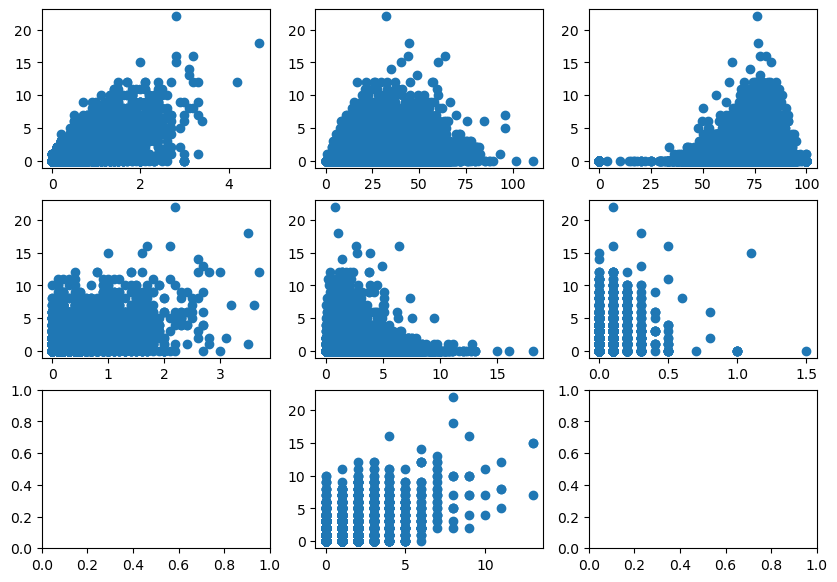

In [14]:
# 어시스트와 관련된 변수들의 상관 관계 관찰

fig, axes = plt.subplots(3, 3, figsize=(10,7))
axes[0, 0].scatter("keyP", "assist", data=df_whos)
axes[0, 1].scatter("avgP", "assist", data=df_whos)
axes[0, 2].scatter("PS", "assist", data=df_whos)
axes[1, 0].scatter("cross", "assist", data=df_whos)
axes[1, 1].scatter("longP", "assist", data=df_whos)
axes[1, 2].scatter("ThrP", "assist", data=df_whos)
axes[2, 1].scatter("mom", "assist", data=df_whos)

print("1. keyP & assist: ", stats.pearsonr(df_whos['keyP'], df_whos['assist']))
print("2. avgP & assist : ", stats.pearsonr(df_whos['avgP'], df_whos['assist']))
print("3. PS & assist : ", stats.pearsonr(df_whos['PS'], df_whos['assist']))
print("4. cross & assist : ", stats.pearsonr(df_whos['cross'], df_whos['assist']))
print("5. longP & assist : ", stats.pearsonr(df_whos['longP'], df_whos['assist']))
print("6. ThrP & assist : ", stats.pearsonr(df_whos['ThrP'], df_whos['assist']))
print("7. MOM & assist : ", stats.pearsonr(df_whos['mom'], df_whos['assist']))

# 예상 외로 평균 패스 횟수가 어시스트와 상관관계가 낮은 모습
# 키패스 횟수와 패스성공률은 높은 상관관계를 보이고 있음
# 롱패스와 스루패스도 높은 상관관계를 보일거 같지만 두 종류의 패스는 성공률이 낮기 때문에 상관관계가 생각보다 낮아보임
# Man of the Match 수상 횟수는 골과 더 상관관계가 있는 모습

**각 변수와 몸값과의 상관 분석**
- 과연 어떤 지표가 높은 선수들이 몸값이 높을까??

In [15]:
df1 = df_trans.drop(['position', 'age', 'nation', 'team', 'matches', 'goals', 'owngoals', 'assists', 'yellowcard', 'second yellow card', 'redcard', 'substitutions in', 'substitutions out'], axis=1)
df = pd.merge(df1, df_whos, left_on='name', right_on='name')

# 트랜스퍼 마켓의 변수들은 정보가 부족하다고 생각
# 몸값과의 상관관계 분석을 위해 이름을 기준으로 merge

In [16]:
df.head()

,name,value,team,league,age,position,match,min,tackle,intercept,...,keyP,Drb,fouled,avgP,PS,cross,longP,ThrP,mom,rating
0,kim min-jae,750.0,Napoli,Italy,26,DF,33,2903,1.6,1.2,...,0.3,0.1,0.2,80.4,90.8,0.1,3.4,0.0,1,7.10
1,takehiro tomiyasu,375.0,Arsenal,England,24,DF,6,656,1.3,0.7,...,0.2,0.0,0.1,19.6,82.5,0.2,0.7,0.0,0,6.34
2,harry souttar,225.0,Leicester,England,24,DF,10,901,1.2,1.0,...,0.3,0.2,0.5,48.3,82.3,0.0,1.8,0.0,0,6.57
3,harry souttar,225.0,Stoke,England2,24,DF,7,630,1.6,1.0,...,0.0,0.1,0.6,46.1,64.4,0.1,4.1,0.0,0,6.68
4,ko itakura,180.0,Borussia M.Gladbach,Germany,26,"DF,MF",20,1802,1.1,1.1,...,0.1,0.4,0.6,62.6,90.8,0.0,1.8,0.0,0,6.75


In [17]:
# 두 사이트의 공통된 선수 4388명
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4388 entries, 0 to 4387
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       4388 non-null   object 
 1   value      4388 non-null   float64
 2   team       4388 non-null   object 
 3   league     4388 non-null   object 
 4   age        4388 non-null   int64  
 5   position   4388 non-null   object 
 6   match      4388 non-null   int64  
 7   min        4388 non-null   int64  
 8   tackle     4388 non-null   float64
 9   intercept  4388 non-null   float64
 10  foul       4388 non-null   float64
 11  clear      4388 non-null   float64
 12  block      4388 non-null   float64
 13  goal       4388 non-null   int64  
 14  assist     4388 non-null   int64  
 15  SPG        4388 non-null   float64
 16  keyP       4388 non-null   float64
 17  Drb        4388 non-null   float64
 18  fouled     4388 non-null   float64
 19  avgP       4388 non-null   float64
 20  PS      

**포지션, 리그에 따른 평균 비교**
- 어떤 포지션, 리그가 가장 가치있을까?

<Axes: xlabel='position', ylabel='value'>

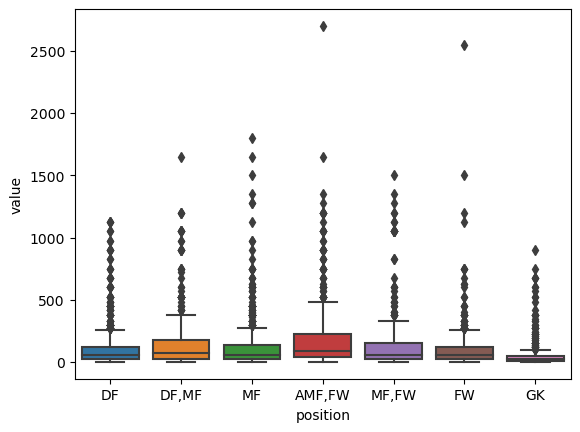

In [171]:
sns.boxplot(x='position', y='value', data=df)

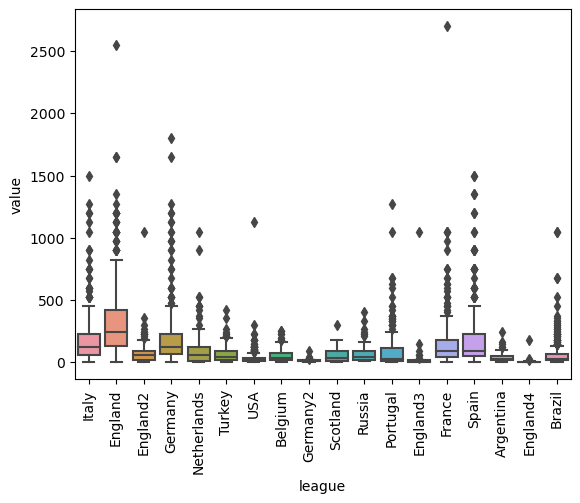

In [173]:
sns.boxplot(x='league', y='value', data=df)
plt.xticks(rotation=90)
plt.show()

In [19]:
# 예상대로 1, 2선(공격수, 윙어, 공격형 미드필더)가 몸값이 가장 높은 모습
# 현대 축구의 핵심으로 평가받는 사이드백 포지션의 평균 몸값도 굉장히 높은 모습

df.groupby('position').value.mean()

position
AMF,FW    184.747730
DF        111.495907
DF,MF     140.378172
FW        110.920455
GK         59.086538
MF        122.811655
MF,FW     140.495567
Name: value, dtype: float64

In [20]:
df.groupby('league').value.mean().sort_values(ascending=False)

league
England        328.722164
Germany        207.676271
Spain          192.507790
Italy          187.230088
France         151.775510
Netherlands    105.448480
Portugal       101.952703
England2        73.506977
Russia          65.650000
Turkey          63.967105
Brazil          60.966078
Scotland        57.646739
Belgium         56.386010
England3        55.225000
Argentina       35.837912
USA             33.672414
Germany2        15.966346
England4        15.552632
Name: value, dtype: float64

**사진은 uefa.com의 리그별 포인트 순위(리그별 몸값 순위와 비슷한 모습)**
![nn](uefa.png)

1. goal & value:  PearsonRResult(statistic=0.32556095305383975, pvalue=7.266411156854728e-109)
2. SPG & value :  PearsonRResult(statistic=0.2685741612061488, pvalue=2.226901710912561e-73)
3. Drb & value :  PearsonRResult(statistic=0.18597607920698028, pvalue=1.9254179020278976e-35)
4. Fouled & value :  PearsonRResult(statistic=0.14275164784800376, pvalue=2.0558407667885677e-21)


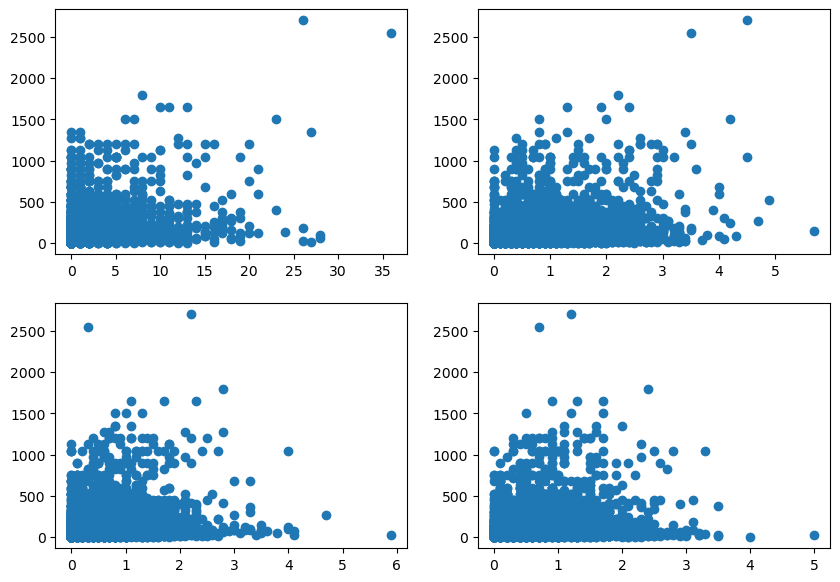

In [21]:
# 공격적인 지표와 몸값의 상관 관계 분석

fig, axes = plt.subplots(2, 2, figsize=(10,7))
axes[0, 0].scatter("goal", "value", data=df)
axes[0, 1].scatter("SPG", "value", data=df)
axes[1, 0].scatter("Drb", "value", data=df)
axes[1, 1].scatter("fouled", "value", data=df)

print("1. goal & value: ", stats.pearsonr(df['goal'], df['value']))
print("2. SPG & value : ", stats.pearsonr(df['SPG'], df['value']))
print("3. Drb & value : ", stats.pearsonr(df['Drb'], df['value']))
print("4. Fouled & value : ", stats.pearsonr(df['fouled'], df['value']))

# 골이 가장 높은 상관관계를 보이고 그 다음으로는 경기 당 슛 횟수
# 나머지 두개의 지표는 그리 높지 않은 상관관계

1. tackle & value:  PearsonRResult(statistic=0.09868502590197079, pvalue=5.7066948877570025e-11)
2. intercept & value :  PearsonRResult(statistic=0.019137346401422763, pvalue=0.20499421005959065)
3. foul & value :  PearsonRResult(statistic=0.07919895095269949, pvalue=1.4959816621176968e-07)
4. clear & value :  PearsonRResult(statistic=-0.031583939175930185, pvalue=0.036428809268998906)
5. block & value :  PearsonRResult(statistic=0.006135563112671331, pvalue=0.684507578310749)


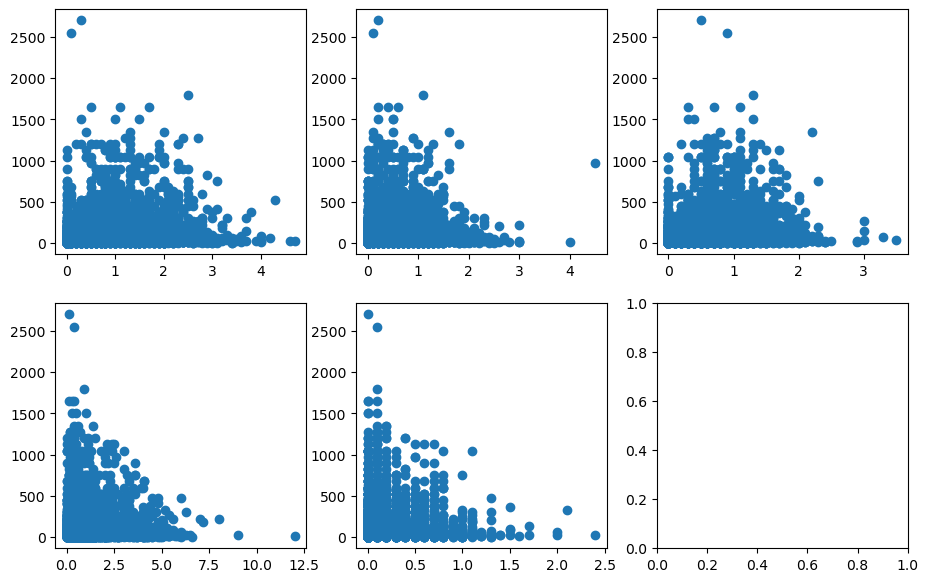

In [22]:
# 수비적인 지표와 몸값의 상관 관계 분석

fig, axes = plt.subplots(2, 3, figsize=(11,7))
axes[0, 0].scatter("tackle", "value", data=df)
axes[0, 1].scatter("intercept", "value", data=df)
axes[0, 2].scatter("foul", "value", data=df)
axes[1, 0].scatter("clear", "value", data=df)
axes[1, 1].scatter("block", "value", data=df)

print("1. tackle & value: ", stats.pearsonr(df['tackle'], df['value']))
print("2. intercept & value : ", stats.pearsonr(df['intercept'], df['value']))
print("3. foul & value : ", stats.pearsonr(df['foul'], df['value']))
print("4. clear & value : ", stats.pearsonr(df['clear'], df['value']))
print("5. block & value : ", stats.pearsonr(df['block'], df['value']))

# 모두 매우 낮은 상관관계를 보이는 모습이다.

1. assist & value:  PearsonRResult(statistic=0.310414541010661, pvalue=1.227425772787633e-98)
2. keyP & value :  PearsonRResult(statistic=0.2435014994606877, pvalue=3.008077284488259e-60)
3. avgP & value :  PearsonRResult(statistic=0.20238875093019887, pvalue=8.692386242640511e-42)
4. PS & value :  PearsonRResult(statistic=0.17252731088024612, pvalue=1.1516419284314796e-30)
5. cross & value :  PearsonRResult(statistic=0.0812461661242706, pvalue=7.073871977757586e-08)
6. longP & value :  PearsonRResult(statistic=-0.04302467512710506, pvalue=0.0043644014186344955)
7. ThrP & value :  PearsonRResult(statistic=0.23682118310738287, pvalue=5.412111281858438e-57)
8. MOM & value :  PearsonRResult(statistic=0.2746249635367101, pvalue=9.086077954591747e-77)


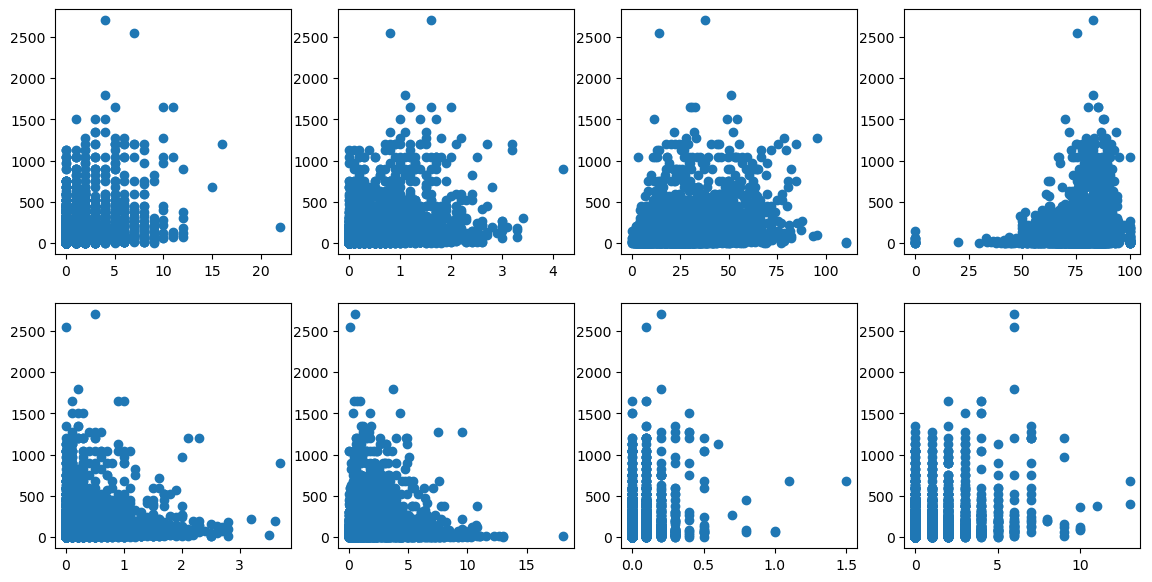

In [23]:
# 패스 지표와 몸값의 상관 관계 분석

fig, axes = plt.subplots(2, 4, figsize=(14,7))
axes[0, 0].scatter("assist", "value", data=df)
axes[0, 1].scatter("keyP", "value", data=df)
axes[0, 2].scatter("avgP", "value", data=df)
axes[0, 3].scatter("PS", "value", data=df)
axes[1, 0].scatter("cross", "value", data=df)
axes[1, 1].scatter("longP", "value", data=df)
axes[1, 2].scatter("ThrP", "value", data=df)
axes[1, 3].scatter("mom", "value", data=df)

print("1. assist & value: ", stats.pearsonr(df['assist'], df['value']))
print("2. keyP & value : ", stats.pearsonr(df['keyP'], df['value']))
print("3. avgP & value : ", stats.pearsonr(df['avgP'], df['value']))
print("4. PS & value : ", stats.pearsonr(df['PS'], df['value']))
print("5. cross & value : ", stats.pearsonr(df['cross'], df['value']))
print("6. longP & value : ", stats.pearsonr(df['longP'], df['value']))
print("7. ThrP & value : ", stats.pearsonr(df['ThrP'], df['value']))
print("8. MOM & value : ", stats.pearsonr(df['mom'], df['value']))

# 어시스트, 키패스, 평균패스횟수, 패스성공률, 스루패스, Man of The Match 가 높은 상관계수

1. age & value:  PearsonRResult(statistic=-0.11053642872824739, pvalue=2.0952274884827658e-13)
2. match & value :  PearsonRResult(statistic=0.24963916201607547, pvalue=2.5017209144898096e-63)
3. min & value :  PearsonRResult(statistic=0.248656751110068, pvalue=7.88913320081744e-63)


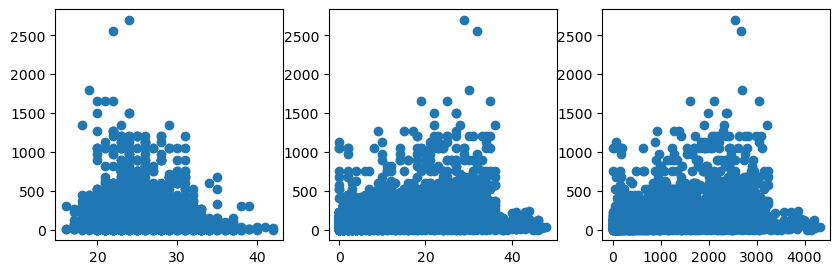

In [24]:
# 그 외의 지표들(나이, 경기 수, 출전시간)

fig, axes = plt.subplots(1, 3, figsize=(10,3))
axes[0].scatter("age", "value", data=df)
axes[1].scatter("match", "value", data=df)
axes[2].scatter("min", "value", data=df)

print("1. age & value: ", stats.pearsonr(df['age'], df['value']))
print("2. match & value : ", stats.pearsonr(df['match'], df['value']))
print("3. min & value : ", stats.pearsonr(df['min'], df['value']))

**타겟 변수로 설정할 평점과의 상관관계 분석**

1. goal & rating :  PearsonRResult(statistic=0.4570390895813262, pvalue=0.0)
2. SPG & rating :  PearsonRResult(statistic=0.4778894319291264, pvalue=0.0)
3. Drb & rating :  PearsonRResult(statistic=0.4253162078734539, pvalue=0.0)
4. Fouled & rating :  PearsonRResult(statistic=0.4025690132771411, pvalue=0.0)


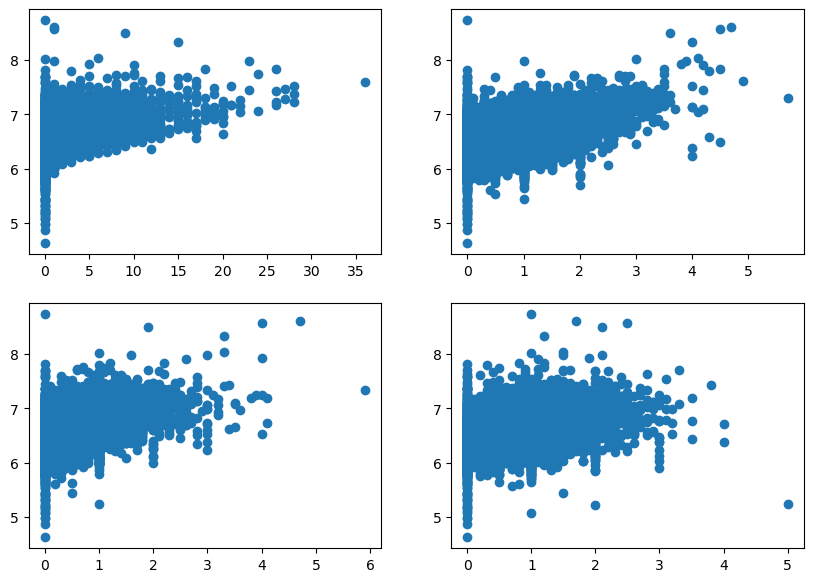

In [25]:
# 공격적인 지표와 평점의 상관 관계 분석

fig, axes = plt.subplots(2, 2, figsize=(10,7))
axes[0, 0].scatter("goal", "rating", data=df_whos)
axes[0, 1].scatter("SPG", "rating", data=df_whos)
axes[1, 0].scatter("Drb", "rating", data=df_whos)
axes[1, 1].scatter("fouled", "rating", data=df_whos)

print("1. goal & rating : ", stats.pearsonr(df_whos['goal'], df_whos['rating']))
print("2. SPG & rating : ", stats.pearsonr(df_whos['SPG'], df_whos['rating']))
print("3. Drb & rating : ", stats.pearsonr(df_whos['Drb'], df_whos['rating']))
print("4. Fouled & rating : ", stats.pearsonr(df_whos['fouled'], df_whos['rating']))

#  공격적인 지표들은 모두 높은 상관관계를 보이는 모습

1. tackle & rating:  PearsonRResult(statistic=0.446804911088448, pvalue=0.0)
2. intercept & rating :  PearsonRResult(statistic=0.3977719723644653, pvalue=0.0)
3. foul & rating :  PearsonRResult(statistic=0.29413301151951987, pvalue=1.1102572057774845e-215)
4. clear & rating :  PearsonRResult(statistic=0.3236256212081512, pvalue=3.1530848835379557e-263)
5. block & rating :  PearsonRResult(statistic=0.25077019941501877, pvalue=2.147412050246194e-155)


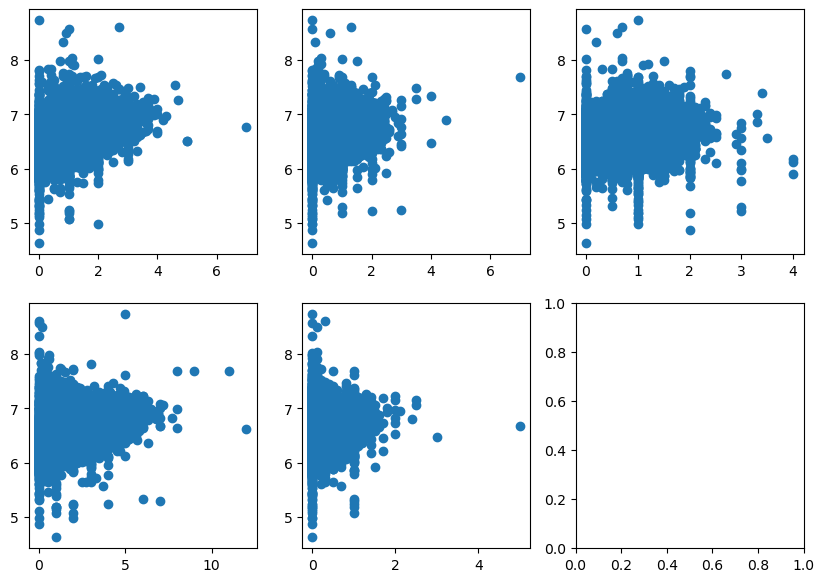

In [26]:
# 수비적인 지표와 평점의 상관 관계 분석

fig, axes = plt.subplots(2, 3, figsize=(10,7))
axes[0, 0].scatter("tackle", "rating", data=df_whos)
axes[0, 1].scatter("intercept", "rating", data=df_whos)
axes[0, 2].scatter("foul", "rating", data=df_whos)
axes[1, 0].scatter("clear", "rating", data=df_whos)
axes[1, 1].scatter("block", "rating", data=df_whos)

print("1. tackle & rating: ", stats.pearsonr(df_whos['tackle'], df_whos['rating']))
print("2. intercept & rating : ", stats.pearsonr(df_whos['intercept'], df_whos['rating']))
print("3. foul & rating : ", stats.pearsonr(df_whos['foul'], df_whos['rating']))
print("4. clear & rating : ", stats.pearsonr(df_whos['clear'], df_whos['rating']))
print("5. block & rating : ", stats.pearsonr(df_whos['block'], df_whos['rating']))

# 공격적인 지표들보단 낮지만 어느 정도의 상관관계를 보이는 모습

1. assist & rating:  PearsonRResult(statistic=0.4868385274987717, pvalue=0.0)
2. keyP & rating :  PearsonRResult(statistic=0.5233783692346684, pvalue=0.0)
3. avgP & rating :  PearsonRResult(statistic=0.594779060584564, pvalue=0.0)
4. PS & rating :  PearsonRResult(statistic=0.14825951586785466, pvalue=2.0051751107446662e-54)
5. cross & rating :  PearsonRResult(statistic=0.3381625753186128, pvalue=1.0089332416113963e-288)
6. longP & rating :  PearsonRResult(statistic=0.34860427352756373, pvalue=6.612866527494052e-308)
7. ThrP & rating :  PearsonRResult(statistic=0.2759260829422431, pvalue=5.172125712293926e-189)
8. MOM & rating :  PearsonRResult(statistic=0.5642358566072605, pvalue=0.0)


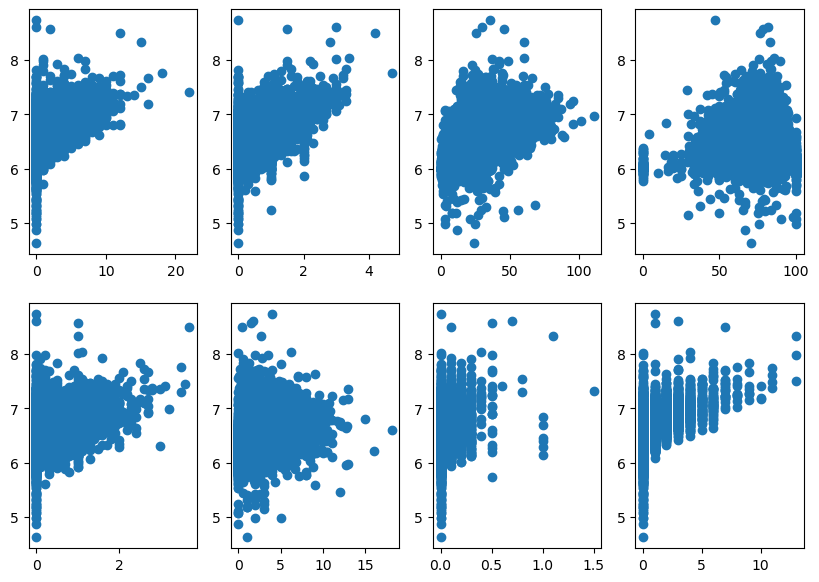

In [27]:
# 패스 지표와 몸값의 상관 관계 분석

fig, axes = plt.subplots(2, 4, figsize=(10,7))
axes[0, 0].scatter("assist", "rating", data=df_whos)
axes[0, 1].scatter("keyP", "rating", data=df_whos)
axes[0, 2].scatter("avgP", "rating", data=df_whos)
axes[0, 3].scatter("PS", "rating", data=df_whos)
axes[1, 0].scatter("cross", "rating", data=df_whos)
axes[1, 1].scatter("longP", "rating", data=df_whos)
axes[1, 2].scatter("ThrP", "rating", data=df_whos)
axes[1, 3].scatter("mom", "rating", data=df_whos)

print("1. assist & rating: ", stats.pearsonr(df_whos['assist'], df_whos['rating']))
print("2. keyP & rating : ", stats.pearsonr(df_whos['keyP'], df_whos['rating']))
print("3. avgP & rating : ", stats.pearsonr(df_whos['avgP'], df_whos['rating']))
print("4. PS & rating : ", stats.pearsonr(df_whos['PS'], df_whos['rating']))
print("5. cross & rating : ", stats.pearsonr(df_whos['cross'], df_whos['rating']))
print("6. longP & rating : ", stats.pearsonr(df_whos['longP'], df_whos['rating']))
print("7. ThrP & rating : ", stats.pearsonr(df_whos['ThrP'], df_whos['rating']))
print("8. MOM & rating : ", stats.pearsonr(df_whos['mom'], df_whos['rating']))

# 어시스트, 키패스, 평균패스횟수, Man of The match 가 높은 상관관계를 보이고 있음
# 평균패스횟수는 상관관계가 높을 것이라고 예상하지 못함
# 한 경기에 패스를 많이 한 선수는 기회 창출을 할 확률이 더 높아져서 이런 상관관계를 보인다고 예상

1. age & rating:  PearsonRResult(statistic=0.20543188460305173, pvalue=7.881460626070564e-104)
2. match & rating :  PearsonRResult(statistic=0.5908527543385063, pvalue=0.0)
3. min & rating :  PearsonRResult(statistic=0.5821829202041144, pvalue=0.0)


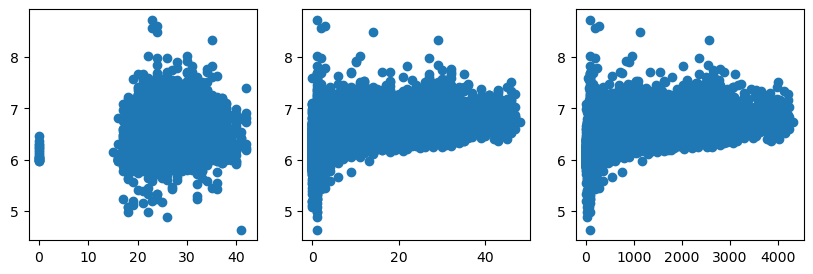

In [28]:
# 그 외의 지표들(나이, 경기 수, 출전시간)

fig, axes = plt.subplots(1, 3, figsize=(10,3))
axes[0].scatter("age", "rating", data=df_whos)
axes[1].scatter("match", "rating", data=df_whos)
axes[2].scatter("min", "rating", data=df_whos)

print("1. age & rating: ", stats.pearsonr(df_whos['age'], df_whos['rating']))
print("2. match & rating : ", stats.pearsonr(df_whos['match'], df_whos['rating']))
print("3. min & rating : ", stats.pearsonr(df_whos['min'], df_whos['rating']))

# 나이와 평점은 높은 상관관계를 보이고 있지는 않고
# 경기 수와 출전시간은 사실 비슷한 개념이어서 비슷한 상관관계를 보이고 있음

PearsonRResult(statistic=0.2891578217901118, pvalue=2.874235876204033e-85)

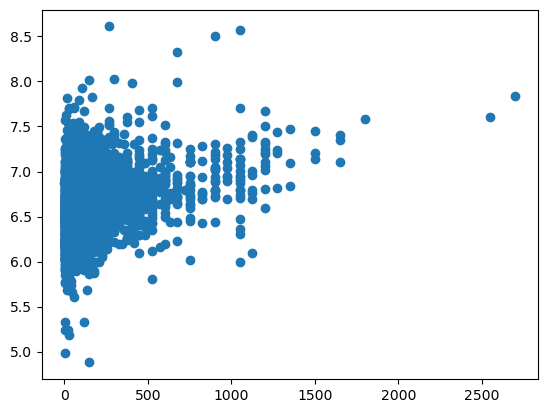

In [29]:
plt.scatter("value", "rating", data=df)
stats.pearsonr(df['value'], df['rating'])

# 실력이 좋은 선수들이 높은 연봉과 높은 몸값을 갖고 있기 때문에
# 높은 상관관계를 가질 것이라고 예상
# 하지만 리그의 수준이 바뀌면 몸값은 달라지지만 평점의 평가 기준과 범위는 바뀌지 않음
# 따라서 상관관계가 생각보다 낮은 것이라고 예상함

In [30]:
temp = df_whos.drop(['name', 'team', 'league', 'position'], axis = 1)

In [31]:
# 전체 상관관계 시각화
temp_df = temp.corr()
temp_df

,age,match,min,tackle,intercept,foul,clear,block,goal,assist,...,keyP,Drb,fouled,avgP,PS,cross,longP,ThrP,mom,rating
age,1.000000,0.232195,0.231346,0.016188,0.091045,0.051251,0.167494,0.119227,0.084288,0.069392,...,0.087799,-0.097828,0.048207,0.242656,0.067416,0.077613,0.245466,0.032464,0.108599,0.205432
match,0.232195,1.000000,0.994850,0.351332,0.332282,0.281491,0.310970,0.249327,0.433359,0.488945,...,0.337548,0.171633,0.306331,0.557210,0.075677,0.223016,0.361421,0.100694,0.519466,0.590853
min,0.231346,0.994850,1.000000,0.340816,0.324993,0.268368,0.310448,0.247633,0.429387,0.482989,...,0.325944,0.162589,0.294019,0.550025,0.074051,0.215380,0.361792,0.093535,0.516548,0.582183
tackle,0.016188,0.351332,0.340816,1.000000,0.623473,0.496727,0.330108,0.352616,0.006287,0.185052,...,0.290181,0.272506,0.348588,0.504849,0.243579,0.255853,0.051948,0.119081,0.123605,0.446805
intercept,0.091045,0.332282,0.324993,0.623473,1.000000,0.359551,0.615936,0.564372,-0.083028,0.046809,...,0.075588,0.044534,0.179816,0.604885,0.245355,0.108149,0.210338,0.009661,0.064794,0.397772
foul,0.051251,0.281491,0.268368,0.496727,0.359551,1.000000,0.173157,0.213106,0.222633,0.200499,...,0.277637,0.270200,0.443280,0.259932,0.148521,0.125959,-0.123688,0.109772,0.168327,0.294133
clear,0.167494,0.310970,0.310448,0.330108,0.615936,0.173157,1.000000,0.740551,-0.104821,-0.095779,...,-0.182558,-0.188823,-0.020846,0.577658,0.112278,-0.109516,0.365982,-0.101412,0.046436,0.323626
block,0.119227,0.249327,0.247633,0.352616,0.564372,0.213106,0.740551,1.000000,-0.087896,-0.067305,...,-0.117396,-0.129260,0.015983,0.505574,0.172647,-0.088871,0.229578,-0.055743,0.011534,0.250770
goal,0.084288,0.433359,0.429387,0.006287,-0.083028,0.222633,-0.104821,-0.087896,1.000000,0.520770,...,0.406965,0.286696,0.318784,0.018548,-0.008531,0.141664,-0.136563,0.170078,0.648603,0.457039
assist,0.069392,0.488945,0.482989,0.185052,0.046809,0.200499,-0.095779,-0.067305,0.520770,1.000000,...,0.653898,0.364857,0.326436,0.184316,0.070378,0.476540,-0.046881,0.282545,0.550242,0.486839


<Axes: >

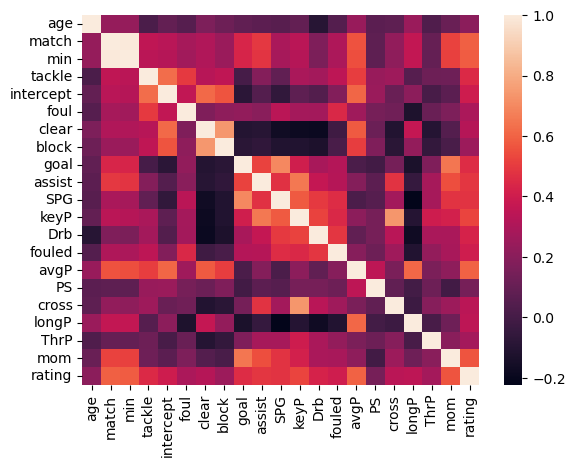

In [32]:
sns.heatmap(temp.corr())

In [33]:
# 타겟 변수 평점과 변수들의 상관관계
temp_df['rating'].sort_values(ascending=False)

rating       1.000000
avgP         0.594779
match        0.590853
min          0.582183
mom          0.564236
keyP         0.523378
assist       0.486839
SPG          0.477889
goal         0.457039
tackle       0.446805
Drb          0.425316
fouled       0.402569
intercept    0.397772
longP        0.348604
cross        0.338163
clear        0.323626
foul         0.294133
ThrP         0.275926
block        0.250770
age          0.205432
PS           0.148260
Name: rating, dtype: float64

In [34]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, age to rating
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        21 non-null     float64
 1   match      21 non-null     float64
 2   min        21 non-null     float64
 3   tackle     21 non-null     float64
 4   intercept  21 non-null     float64
 5   foul       21 non-null     float64
 6   clear      21 non-null     float64
 7   block      21 non-null     float64
 8   goal       21 non-null     float64
 9   assist     21 non-null     float64
 10  SPG        21 non-null     float64
 11  keyP       21 non-null     float64
 12  Drb        21 non-null     float64
 13  fouled     21 non-null     float64
 14  avgP       21 non-null     float64
 15  PS         21 non-null     float64
 16  cross      21 non-null     float64
 17  longP      21 non-null     float64
 18  ThrP       21 non-null     float64
 19  mom        21 non-null     float64
 20  rating     

## 분석 타겟 설정 및 예측(선수) ##

In [35]:
# 변수의 개수가 너무 많다고 생각하여 통용되는 변수는 제거 또는 합계
temp2 = df_whos.drop(['match'], axis = 1)
temp2['defenceaction'] = df_whos['tackle'] + df_whos['intercept'] + df_whos['clear'] + df_whos['block']
temp2['specialpass'] = df_whos['cross'] + df_whos['longP'] + df_whos['ThrP']
temp2 = temp2.drop(['tackle', 'intercept', 'clear', 'block', 'cross', 'longP', 'ThrP'], axis = 1)

In [36]:
temp2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10861 entries, 0 to 10860
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           10861 non-null  object 
 1   team           10861 non-null  object 
 2   league         10861 non-null  object 
 3   age            10861 non-null  int64  
 4   position       10861 non-null  object 
 5   min            10861 non-null  int64  
 6   foul           10861 non-null  float64
 7   goal           10861 non-null  int64  
 8   assist         10861 non-null  int64  
 9   SPG            10861 non-null  float64
 10  keyP           10861 non-null  float64
 11  Drb            10861 non-null  float64
 12  fouled         10861 non-null  float64
 13  avgP           10861 non-null  float64
 14  PS             10861 non-null  float64
 15  mom            10861 non-null  int64  
 16  rating         10861 non-null  float64
 17  defenceaction  10861 non-null  float64
 18  specia

In [37]:
# 중선형회귀분석을 위한 모델 생성
m = ols ('rating~age+min+foul+goal+assist+SPG+keyP+Drb+fouled+avgP+PS+mom+defenceaction+specialpass', data=temp2).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     2163.
Date:                Sat, 10 Jun 2023   Prob (F-statistic):               0.00
Time:                        18:35:52   Log-Likelihood:                 3727.0
No. Observations:               10861   AIC:                            -7424.
Df Residuals:                   10846   BIC:                            -7315.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.0131      0.013    468.350      0.000       5.988       6.038
age               0.0024      0.000      6.407      0.000       0.002       0.003
min           -2.726e-06   2.67e-06     -1.019      0.308   -7.97e-06    2.52e-06
foul             -0.0442      0.004    -10.475      0.000      -0.053      -0.036
goal              0.0199      0.001     19.207      0.000       0.018       0.022
assist            0.0097      0.001      6.502      0.000       0.007       0.013
SPG               0.0925      0.004     21.787      0.000       0.084       0.101
keyP              0.0847      0.005     15.964      0.000       0.074       0.095
Drb               0.1285      0.004     29.862      0.000       0.120       0.137
fouled            0.0208      0.004      5.245      0.000       0.013       0.029
avgP              0.0034      0.000     14.941      0.000       0.003       0.004
PS               -0.0007      0.000     -5.372      0.000      -0.001      -0.000
mom               0.0389      0.002     18.203      0.000       0.035       0.043
defenceaction     0.0465      0.001     41.118      0.000       0.044       0.049
specialpass       0.0439      0.001     32.211      0.000       0.041       0.047
==============================================================================
Omnibus:                     1993.361   Durbin-Watson:                   1.445
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            48641.677
Skew:                           0.182   Prob(JB):                         0.00
Kurtosis:                      13.361   Cond. No.                     1.13e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

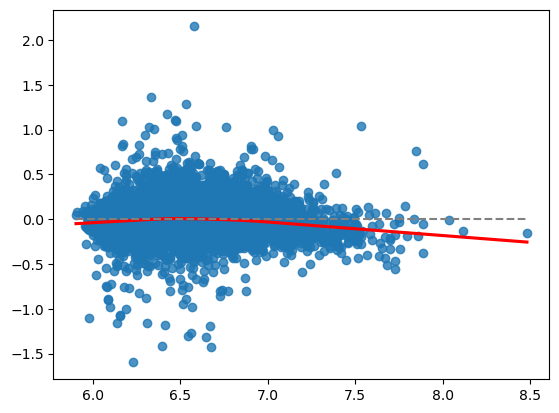

In [38]:
# 회귀 모델이 적합한지 판단하기 위해 잔차 분석
# 모형의 선형성(빨간 선이 실선에서 크게 벗어나지 않아야함)

fitted = m.predict(temp2)
residual = temp2['rating'] - fitted
sns.regplot(x=fitted, y=residual, lowess=True, line_kws={'color': 'red'})
plt.plot([fitted.min(), fitted.max()], [0, 0], '--', color = 'grey')

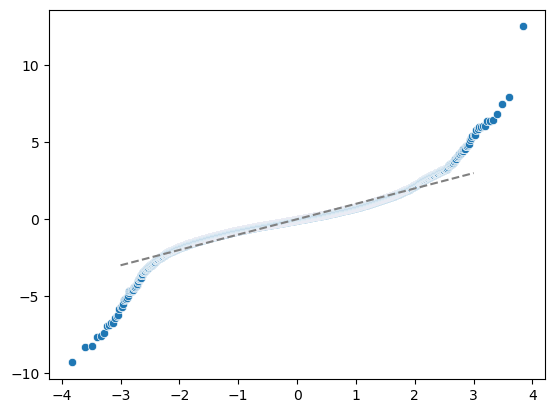

In [41]:
#잔차의 정규성(잔차가 정규분포를 띄면 Q-Q Plot에서 점들이 점선을 따라 배치되어 있어야 한다.)
import scipy

sr = scipy.stats.zscore(residual)
(x, y), _ = scipy.stats.probplot(sr)
sns.scatterplot(x=x, y=y)
plt.plot([-3, 3], [-3, 3], '--', color = 'grey')

<Axes: >

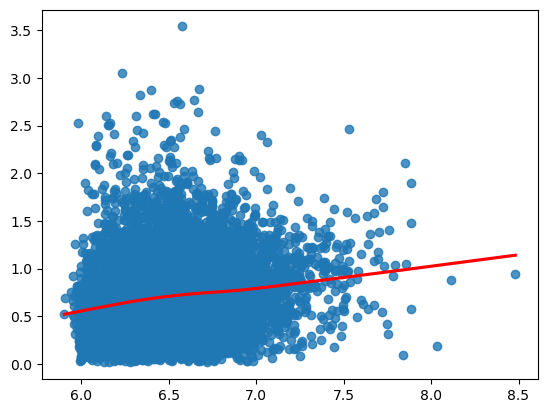

In [43]:
# 잔차의 등분산성(빨간 선이 수평선에 가까워야 한다.)
# 세 가지의 그래프로 회귀 에측 모델로 사용하기 적합하다고 판단
import numpy as np
sns.regplot(x=fitted, y=np.sqrt(np.abs(sr)),lowess = True, line_kws = {'color' : 'red'})

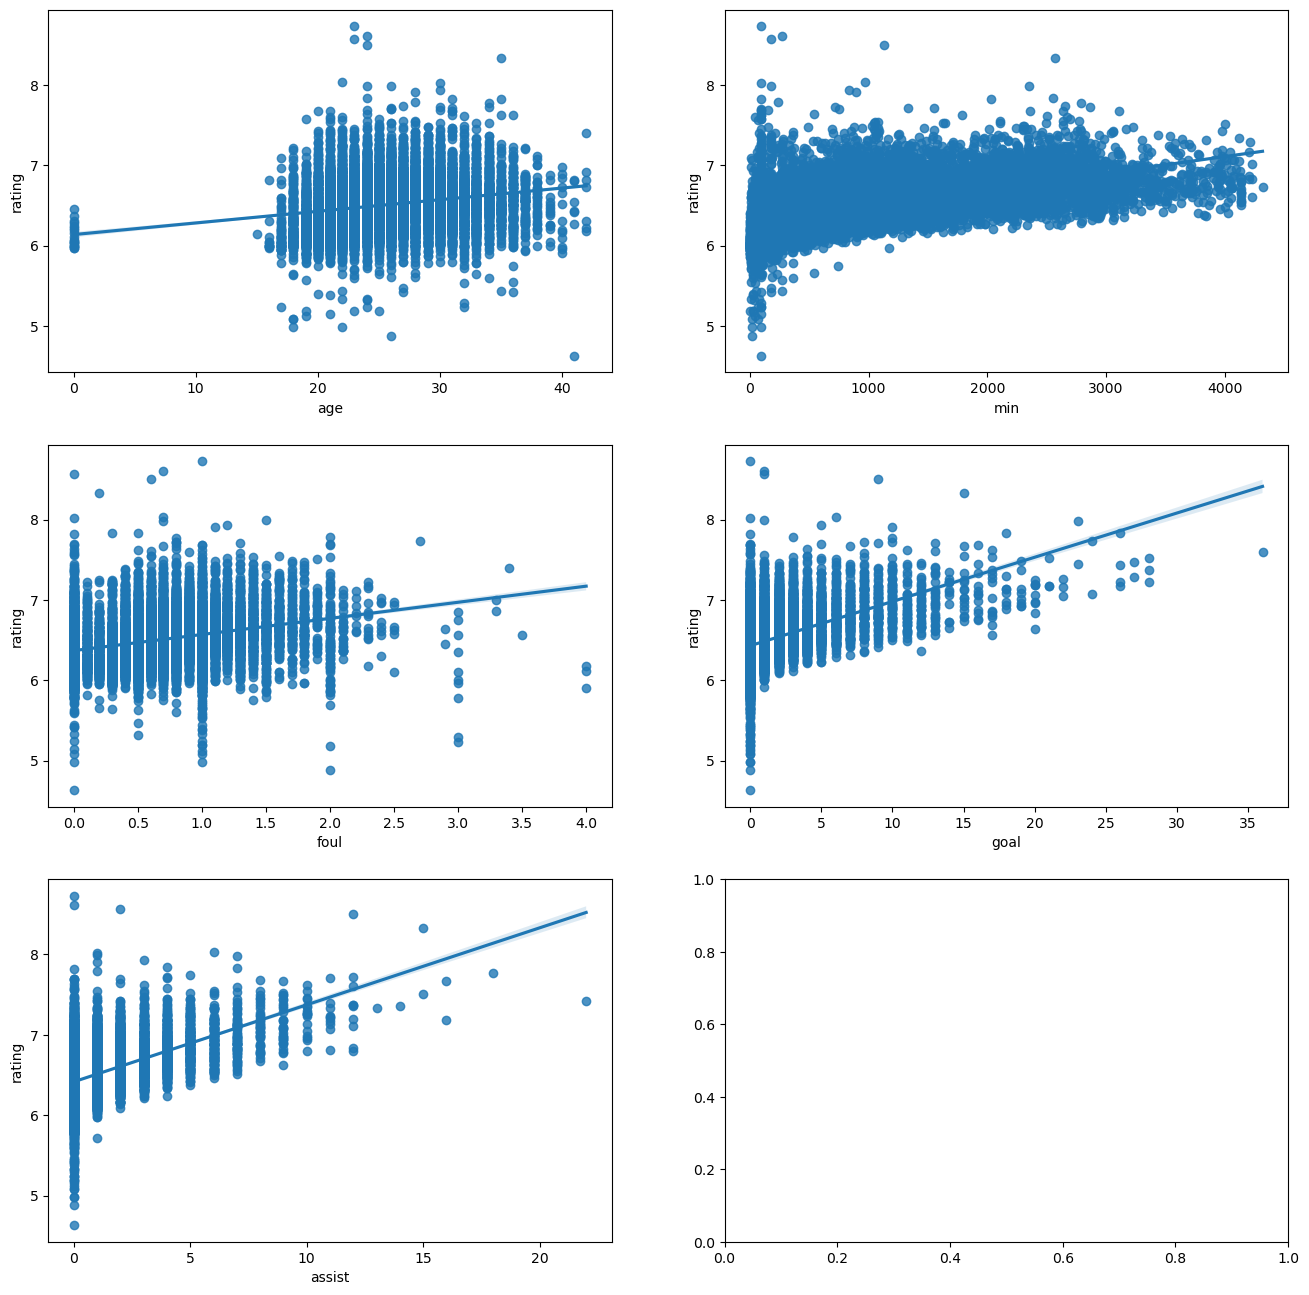

In [51]:
fig, axs = plt.subplots(figsize=(16, 16), ncols=2, nrows=3)

x_features = ['age', 'min', 'foul', 'goal', 'assist']
#변수 별 상관 관계 시각화

for i, feature in enumerate(x_features):
      row = int(i/2)
      col = i%2

      sns.regplot(x=feature, y='rating', data=temp2, ax=axs[row][col])

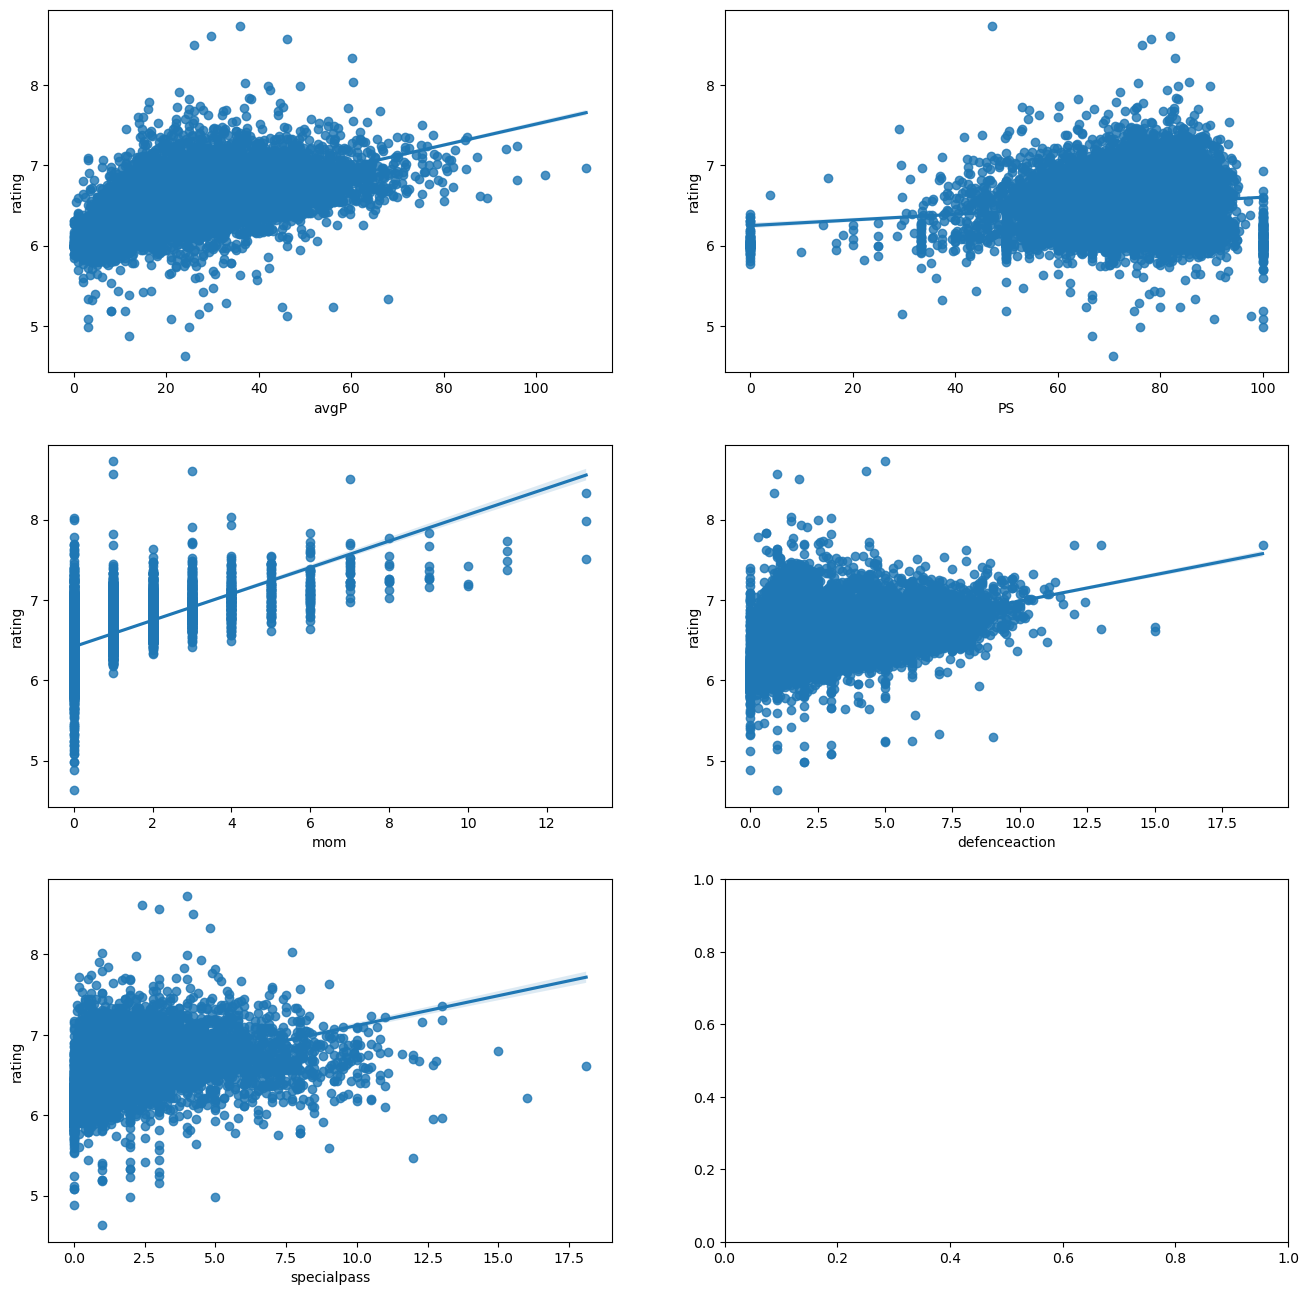

In [52]:
fig, axs = plt.subplots(figsize=(16, 16), ncols=2, nrows=3)

x_features = ['avgP', 'PS', 'mom','defenceaction', 'specialpass']
#변수 별 상관 관계 시각화

for i, feature in enumerate(x_features):
      row = int(i/2)
      col = i%2

      sns.regplot(x=feature, y='rating', data=temp2, ax=axs[row][col])

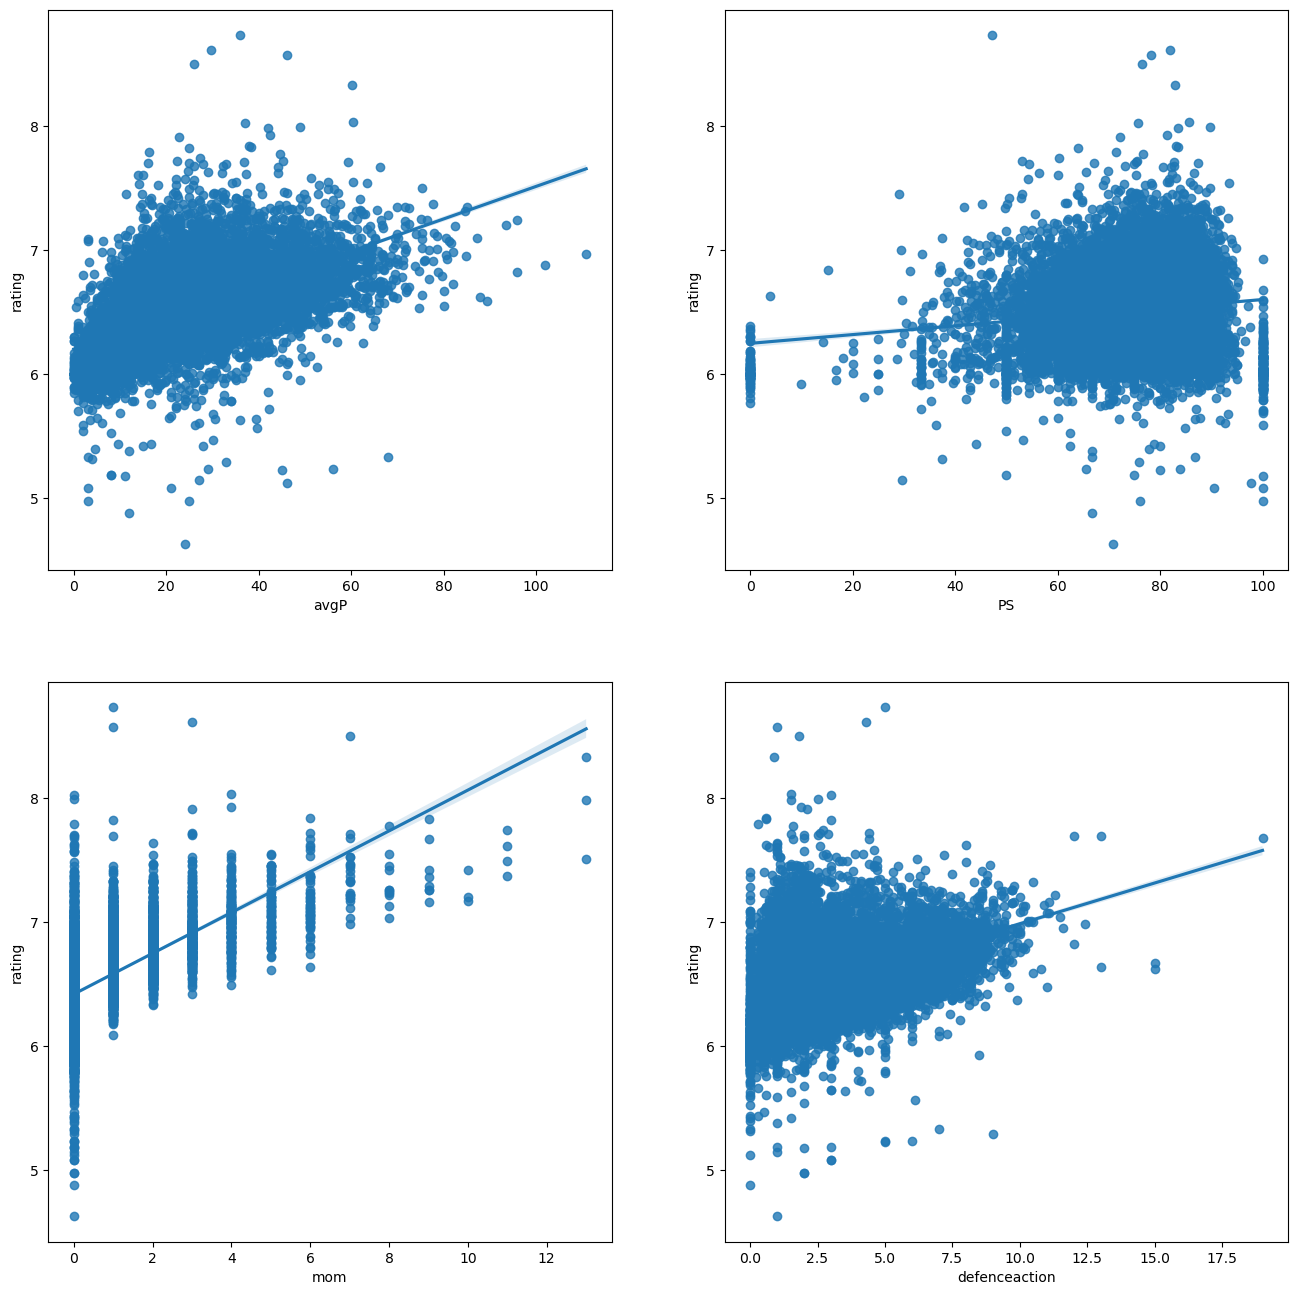

In [53]:
fig, axs = plt.subplots(figsize=(16, 16), ncols=2, nrows=2)

x_features = ['avgP', 'PS', 'mom','defenceaction']
#변수 별 상관 관계 시각화

for i, feature in enumerate(x_features):
      row = int(i/2)
      col = i%2

      sns.regplot(x=feature, y='rating', data=temp2, ax=axs[row][col])

In [54]:
# nominal 변수들 삭제
temp2 = temp2.drop(['name', 'team', 'league', 'position'], axis = 1)

In [55]:
Y = temp2['rating']
X = temp2.drop(['rating'], axis=1, inplace=False)

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [58]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
Y_predict = lr.predict(X_test)

In [63]:
print('Y 절편 값: ',  np.round(lr.intercept_, 2))
print('회귀 계수 값: ', np.round(lr.coef_, 4))

Y 절편 값:  6.01
회귀 계수 값:  [ 0.0025  0.     -0.0488  0.0196  0.0094  0.0878  0.0854  0.1328  0.0202
  0.0032 -0.0007  0.0391  0.0476  0.0424]


In [64]:
coef = pd.Series(data=np.round(lr.coef_, 2), index=X.columns)
coef

age              0.00
min              0.00
foul            -0.05
goal             0.02
assist           0.01
SPG              0.09
keyP             0.09
Drb              0.13
fouled           0.02
avgP             0.00
PS              -0.00
mom              0.04
defenceaction    0.05
specialpass      0.04
dtype: float64

In [59]:
print ( Y_predict)
print ( Y_test)

[6.18824503 6.76005412 6.8617404  ... 6.03654207 7.26131355 6.58496568]
2978    6.68
8522    6.66
7564    6.62
8100    6.61
7383    7.18
        ... 
596     6.91
8705    6.15
3856    6.10
8777    7.23
4137    6.53
Name: rating, Length: 3259, dtype: float64


In [60]:
# MSE 오류 0.031 테스트 셋의 예측이 잘 되는 모습

mse = mean_squared_error(Y_test, Y_predict)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse, rmse))

MSE : 0.031, RMSE : 0.175


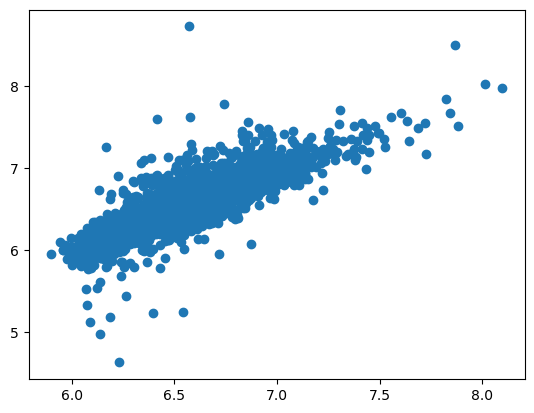

In [61]:
# 실측값과 예측값 시각화

plt.scatter(Y_predict, Y_test)

In [89]:
# 만든 회귀 모델로 선수 평점을 예측하는 모델
def predictRating() :
    print("평점을 예측하고 싶은 선수의 정보를 입력해주세요.")
    age = int(input("age (%d ~ %d): "%(temp2['age'].min(), temp2['age'].max())))
    mins = int(input("min (%d ~ %d): "%(temp2['min'].min(), temp2['min'].max())))
    foul = float(input("foul (%1f ~ %1f): "%(temp2['foul'].min(), temp2['foul'].max())))
    goal = int(input("goal (%d ~ %d): "%(temp2['goal'].min(), temp2['goal'].max())))
    assist = int(input("assist (%d ~ %d): "%(temp2['assist'].min(), temp2['assist'].max())))
    SPG = float(input("SPG (%f ~ %f): "%(temp2['SPG'].min(), temp2['SPG'].max())))
    keyP = float(input("keyP (%f ~ %f): "%(temp2['keyP'].min(), temp2['keyP'].max())))
    Drb = float(input("Drb (%f ~ %f): "%(temp2['Drb'].min(), temp2['Drb'].max())))
    fouled = float(input("fouled (%f ~ %f): "%(temp2['fouled'].min(), temp2['fouled'].max())))
    avgP = float(input("avgP (%f ~ %f): "%(temp2['avgP'].min(), temp2['avgP'].max())))
    PS = float(input("PS (%f ~ %f): "%(temp2['PS'].min(), temp2['PS'].max())))
    mom = int(input("mom (%d ~ %d): "%(temp2['mom'].min(), temp2['mom'].max())))
    defenceaction = float(input("defenceaction (%f ~ %f): "%(temp2['defenceaction'].min(), temp2['defenceaction'].max())))
    specialpass = float(input("specialpass (%f ~ %f): "%(temp2['specialpass'].min(), temp2['specialpass'].max())))
    
    player_predict = lr.predict([[age, mins, foul, goal, assist, SPG, keyP, Drb, fouled, avgP, PS, mom, defenceaction, specialpass]])
    
    print("이 선수의 예상 평점(rating)는 %.2f 입니다." %player_predict)

In [90]:
# 저번 시즌 K리그 MVP에 선정된 이청용 선수의 평점 예측
# 네이버 스포츠에서 평가한 이청용 선수의 저번시즌 평점은 7.3

predictRating()

평점을 예측하고 싶은 선수의 정보를 입력해주세요.
age (0 ~ 42): 35
min (1 ~ 4320): 2397
foul (0.000000 ~ 4.000000): 0.4
goal (0 ~ 36): 3
assist (0 ~ 22): 2
SPG (0.000000 ~ 5.700000): 0.74
keyP (0.000000 ~ 4.700000): 0.71
Drb (0.000000 ~ 5.900000): 0.63
fouled (0.000000 ~ 5.000000): 1.8
avgP (0.000000 ~ 110.800000): 51
PS (0.000000 ~ 100.000000): 89.3
mom (0 ~ 13): 5
defenceaction (0.000000 ~ 19.000000): 6.02
specialpass (0.000000 ~ 18.100000): 17.6
이 선수의 예상 평점(rating)는 7.73 입니다.


C:\Users\kchk0\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## 분석 타겟 설정 및 예측(팀) ##

In [97]:
df_team = pd.read_csv('whoscored_team.csv')

In [98]:
df_team.head(5)

,teamname,goal,SPG,PS,aerialswon,blocks,tackles,intecept,foul,offside,SOTPG,Drb,fouled,rating
0,Manchester City,94,15.8,89.2,11.6,7.7,12.4,5.9,9.1,1.3,5.8,8.8,10.1,6.90
1,Arsenal,88,15.6,85.4,12.9,9.0,14.9,6.2,9.8,1.5,5.4,9.4,11.4,6.81
2,Newcastle,68,15.0,79.8,14.7,10.2,16.0,8.8,10.7,1.9,5.2,9.2,10.5,6.79
3,Manchester United,58,15.6,82.3,12.3,12.7,17.3,9.3,11.2,2.1,5.7,8.4,7.8,6.77
4,Liverpool,75,15.9,84.2,12.7,9.7,15.5,8.8,10.7,2.2,5.6,8.5,8.4,6.75


1. goal & rating:  PearsonRResult(statistic=0.5343365152545537, pvalue=2.075133876342903e-28)
2. SPG & rating :  PearsonRResult(statistic=0.7367279486848394, pvalue=7.90027507428539e-64)
3. PS & rating :  PearsonRResult(statistic=0.36313462936633323, pvalue=7.52065234960621e-13)
4. aerialswon & rating :  PearsonRResult(statistic=-0.03723162188547714, pvalue=0.47764670761575423)
5. blocks & rating :  PearsonRResult(statistic=-0.5509859039888584, pvalue=1.9020154456135364e-30)
6. tackles & rating :  PearsonRResult(statistic=0.05117675481930444, pvalue=0.32888619150977366)
7. intercept & rating :  PearsonRResult(statistic=-0.09421836515318008, pvalue=0.07180626765346101)
8. foul & rating :  PearsonRResult(statistic=-0.20438624883574358, pvalue=8.20210837670781e-05)
9. offside & rating :  PearsonRResult(statistic=0.09696070316820943, pvalue=0.06388373585576072)
10. SOTPG & rating :  PearsonRResult(statistic=0.7844112858272831, pvalue=1.6513058338843426e-77)
11. Drb & rating :  PearsonRResu

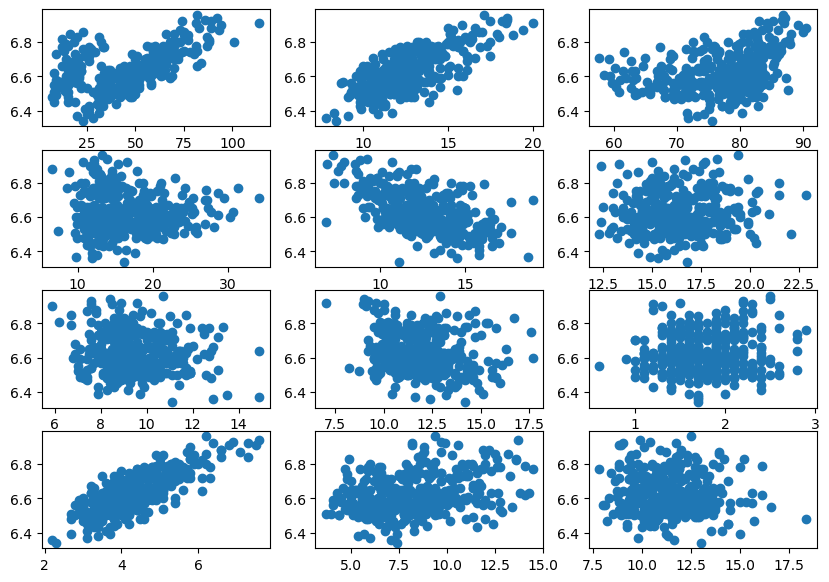

In [102]:
# 타겟 변수 rating과 다른변수의 상관관계 확인

fig, axes = plt.subplots(4, 3, figsize=(10,7))
axes[0, 0].scatter("goal", "rating", data=df_team)
axes[0, 1].scatter("SPG", "rating", data=df_team)
axes[0, 2].scatter("PS", "rating", data=df_team)
axes[1, 0].scatter("aerialswon", "rating", data=df_team)
axes[1, 1].scatter("blocks", "rating", data=df_team)
axes[1, 2].scatter("tackles", "rating", data=df_team)
axes[2, 0].scatter("intecept", "rating", data=df_team)
axes[2, 1].scatter("foul", "rating", data=df_team)
axes[2, 2].scatter("offside", "rating", data=df_team)
axes[3, 0].scatter("SOTPG", "rating", data=df_team)
axes[3, 1].scatter("Drb", "rating", data=df_team)
axes[3, 2].scatter("fouled", "rating", data=df_team)

print("1. goal & rating: ", stats.pearsonr(df_team['goal'], df_team['rating']))
print("2. SPG & rating : ", stats.pearsonr(df_team['SPG'], df_team['rating']))
print("3. PS & rating : ", stats.pearsonr(df_team['PS'], df_team['rating']))
print("4. aerialswon & rating : ", stats.pearsonr(df_team['aerialswon'], df_team['rating']))
print("5. blocks & rating : ", stats.pearsonr(df_team['blocks'], df_team['rating']))
print("6. tackles & rating : ", stats.pearsonr(df_team['tackles'], df_team['rating']))
print("7. intercept & rating : ", stats.pearsonr(df_team['intecept'], df_team['rating']))
print("8. foul & rating : ", stats.pearsonr(df_team['foul'], df_team['rating']))
print("9. offside & rating : ", stats.pearsonr(df_team['offside'], df_team['rating']))
print("10. SOTPG & rating : ", stats.pearsonr(df_team['SOTPG'], df_team['rating']))
print("11. Drb & rating : ", stats.pearsonr(df_team['Drb'], df_team['rating']))
print("12. fouled & rating : ", stats.pearsonr(df_team['fouled'], df_team['rating']))

In [104]:
df_team = df_team.drop(['teamname'], axis = 1)

In [105]:
#상관관계 시각화
a = df_team.corr()
a

,goal,SPG,PS,aerialswon,blocks,tackles,intecept,foul,offside,SOTPG,Drb,fouled,rating
goal,1.000000,0.441553,0.142825,0.068752,-0.446654,-0.238580,-0.199253,-0.406411,0.073649,0.541433,-0.290053,-0.266661,0.534337
SPG,0.441553,1.000000,0.473117,-0.202169,-0.511405,-0.041221,-0.123280,-0.066785,0.196762,0.902744,0.331159,0.040648,0.736728
PS,0.142825,0.473117,1.000000,-0.815454,-0.180759,-0.046691,-0.172555,-0.009368,0.138330,0.541191,0.567791,0.267086,0.363135
aerialswon,0.068752,-0.202169,-0.815454,1.000000,-0.102674,-0.054944,-0.000204,-0.031942,-0.095210,-0.296797,-0.498342,-0.228551,-0.037232
blocks,-0.446654,-0.511405,-0.180759,-0.102674,1.000000,0.085809,0.150342,0.064445,-0.111985,-0.452690,-0.088611,-0.026389,-0.550986
tackles,-0.238580,-0.041221,-0.046691,-0.054944,0.085809,1.000000,0.341397,0.252043,0.025944,-0.032328,0.310458,0.044775,0.051177
intecept,-0.199253,-0.123280,-0.172555,-0.000204,0.150342,0.341397,1.000000,0.090954,-0.037023,-0.083858,-0.080465,-0.111982,-0.094218
foul,-0.406411,-0.066785,-0.009368,-0.031942,0.064445,0.252043,0.090954,1.000000,0.187379,-0.133998,0.215710,0.429511,-0.204386
offside,0.073649,0.196762,0.138330,-0.095210,-0.111985,0.025944,-0.037023,0.187379,1.000000,0.180260,0.012847,0.129932,0.096961
SOTPG,0.541433,0.902744,0.541191,-0.296797,-0.452690,-0.032328,-0.083858,-0.133998,0.180260,1.000000,0.323764,0.001842,0.784411


<Axes: >

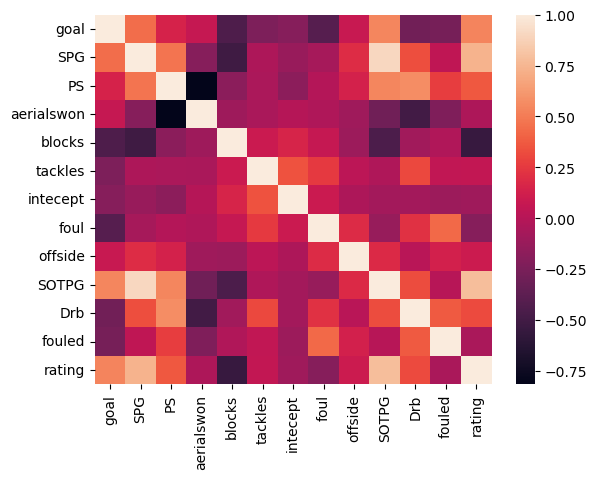

In [106]:
sns.heatmap(a)

In [108]:
Y = df_team['rating']
X = df_team.drop(['rating'], axis=1, inplace=False)

In [109]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [110]:
lr = LinearRegression()
lr.fit(X_train, Y_train)
Y_predict = lr.predict(X_test)
Y_predict

array([6.52360103, 6.56058686, 6.60983218, 6.63804606, 6.6285159 ,
       6.57680309, 6.64780691, 6.49376659, 6.4599754 , 6.79433184,
       6.69490647, 6.58542198, 6.68247954, 6.56784011, 6.51106652,
       6.54883439, 6.53076667, 6.62171248, 6.5993497 , 6.44069468,
       6.5357613 , 6.5335073 , 6.62083416, 6.65452732, 6.58278322,
       6.48292064, 6.82841753, 6.54656528, 6.67481729, 6.7239552 ,
       6.71585042, 6.76938832, 6.54710799, 6.58385501, 6.7405801 ,
       6.59536168, 6.55184001, 6.64040295, 6.62002216, 6.71426599,
       6.7056817 , 6.58506663, 6.59861979, 6.77586893, 6.71535329,
       6.51493783, 6.74216725, 6.62253724, 6.70843559, 6.52779225,
       6.56995876, 6.724735  , 6.57551812, 6.96719568, 6.63555271,
       6.59245099, 6.73954034, 6.53517813, 6.73962935, 6.67809393,
       6.66259451, 6.78163043, 6.67416669, 6.71661654, 6.65233094,
       6.56591598, 6.58649497, 6.65713716, 6.48156941, 6.57427117,
       6.66358734, 6.84359444, 6.56669003, 6.67960632])

In [111]:
print('Y 절편 값: ', lr.intercept_)
print('회귀 계수 값: ', np.round(lr.coef_, 1))

Y 절편 값:  5.750474703836622
회귀 계수 값:  [ 0.   0.   0.   0.  -0.   0.   0.  -0.   0.   0.1  0.  -0. ]


In [112]:
coef = pd.Series(data =lr.coef_, index=X.columns)

print (coef)

goal          0.001056
SPG           0.000623
PS            0.004196
aerialswon    0.010444
blocks       -0.007260
tackles       0.007994
intecept      0.001790
foul         -0.008013
offside       0.000965
SOTPG         0.065529
Drb           0.013084
fouled       -0.002373
dtype: float64


In [113]:
# 오류가 거의 없는 모습
mse = mean_squared_error(Y_test, Y_predict)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse, rmse))

MSE : 0.004, RMSE : 0.061


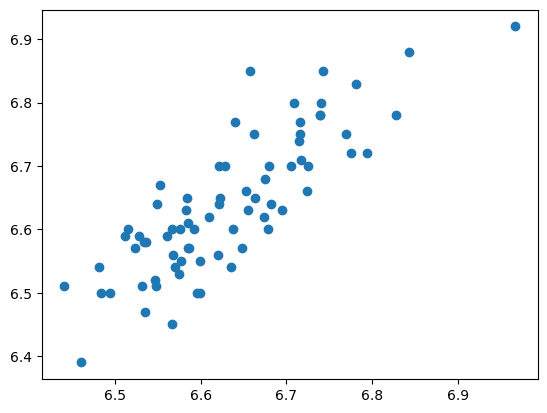

In [114]:
# 실측값과 예측값 시각화
plt.scatter(Y_predict, Y_test)

In [132]:
# 팀 평점 예측 함수
def teamRating() :
    print("평점을 예측하고 싶은 팀의 정보를 입력해주세요.")
    goal = int(input("goal (%d ~ %d): "%(df_team['goal'].min(), df_team['goal'].max())))
    SPG = int(input("SPG (%f ~ %f): "%(df_team['SPG'].min(), df_team['SPG'].max())))
    PS = float(input("PS (%1f ~ %1f): "%(df_team['PS'].min(), df_team['PS'].max())))
    aerialswon = int(input("aerialswon (%f ~ %f): "%(df_team['aerialswon'].min(), df_team['aerialswon'].max())))
    blocks = float(input("blocks (%f ~ %f): "%(df_team['blocks'].min(), df_team['blocks'].max())))
    tackles = float(input("tackles (%f ~ %f): "%(df_team['tackles'].min(), df_team['tackles'].max())))
    intecept = float(input("intecept (%f ~ %f): "%(df_team['intecept'].min(), df_team['intecept'].max())))
    foul = float(input("foul (%f ~ %f): "%(df_team['foul'].min(), df_team['foul'].max())))
    offside = int(input("offside (%f ~ %f): "%(df_team['offside'].min(), df_team['offside'].max())))
    SOTPG = float(input("SOTPG (%f ~ %f): "%(df_team['SOTPG'].min(), df_team['SOTPG'].max())))
    Drb = float(input("Drb (%f ~ %f): "%(df_team['Drb'].min(), df_team['Drb'].max())))
    fouled = float(input("fouled (%f ~ %f): "%(df_team['fouled'].min(), df_team['fouled'].max())))
    
    player_predict = lr.predict([[goal, SPG / 38, PS, aerialswon/ 38, blocks / 38, tackles / 38, intecept / 38, foul / 38, offside / 38, SOTPG / 38, Drb / 38, fouled / 38]])
    
    return player_predict

In [133]:
Gangwon = teamRating()

평점을 예측하고 싶은 팀의 정보를 입력해주세요.
goal (7 ~ 114): 50
SPG (7.800000 ~ 20.000000): 384
PS (57.700000 ~ 90.500000): 79.6
aerialswon (6.600000 ~ 34.200000): 842
blocks (6.800000 ~ 19.000000): 861
tackles (12.300000 ~ 22.900000): 813
intecept (5.900000 ~ 14.900000): 1237
foul (7.000000 ~ 17.700000): 410
offside (0.600000 ~ 2.900000): 49
SOTPG (2.200000 ~ 7.600000): 130
Drb (3.700000 ~ 14.500000): 304
fouled (7.800000 ~ 18.400000): 403


C:\Users\kchk0\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [135]:
Kimcheon = teamRating()

평점을 예측하고 싶은 팀의 정보를 입력해주세요.
goal (7 ~ 114): 45
SPG (7.800000 ~ 20.000000): 442
PS (57.700000 ~ 90.500000): 86.7
aerialswon (6.600000 ~ 34.200000): 670
blocks (6.800000 ~ 19.000000): 758
tackles (12.300000 ~ 22.900000): 808
intecept (5.900000 ~ 14.900000): 1210
foul (7.000000 ~ 17.700000): 398
offside (0.600000 ~ 2.900000): 44
SOTPG (2.200000 ~ 7.600000): 159
Drb (3.700000 ~ 14.500000): 282
fouled (7.800000 ~ 18.400000): 409


C:\Users\kchk0\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [137]:
Daegu = teamRating()

평점을 예측하고 싶은 팀의 정보를 입력해주세요.
goal (7 ~ 114): 52
SPG (7.800000 ~ 20.000000): 448
PS (57.700000 ~ 90.500000): 77.6
aerialswon (6.600000 ~ 34.200000): 911
blocks (6.800000 ~ 19.000000): 845
tackles (12.300000 ~ 22.900000): 876
intecept (5.900000 ~ 14.900000): 1257
foul (7.000000 ~ 17.700000): 557
offside (0.600000 ~ 2.900000): 57
SOTPG (2.200000 ~ 7.600000): 150
Drb (3.700000 ~ 14.500000): 300
fouled (7.800000 ~ 18.400000): 408


C:\Users\kchk0\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [139]:
Seoul = teamRating()

평점을 예측하고 싶은 팀의 정보를 입력해주세요.
goal (7 ~ 114): 43
SPG (7.800000 ~ 20.000000): 457
PS (57.700000 ~ 90.500000): 88.1
aerialswon (6.600000 ~ 34.200000): 722
blocks (6.800000 ~ 19.000000): 745
tackles (12.300000 ~ 22.900000): 658
intecept (5.900000 ~ 14.900000): 1333
foul (7.000000 ~ 17.700000): 401
offside (0.600000 ~ 2.900000): 56
SOTPG (2.200000 ~ 7.600000): 151
Drb (3.700000 ~ 14.500000): 280
fouled (7.800000 ~ 18.400000): 380


C:\Users\kchk0\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [140]:
Seongnam = teamRating()

평점을 예측하고 싶은 팀의 정보를 입력해주세요.
goal (7 ~ 114): 37
SPG (7.800000 ~ 20.000000): 434
PS (57.700000 ~ 90.500000): 81.1
aerialswon (6.600000 ~ 34.200000): 846
blocks (6.800000 ~ 19.000000): 856
tackles (12.300000 ~ 22.900000): 850
intecept (5.900000 ~ 14.900000): 1186
foul (7.000000 ~ 17.700000): 437
offside (0.600000 ~ 2.900000): 56
SOTPG (2.200000 ~ 7.600000): 149
Drb (3.700000 ~ 14.500000): 277
fouled (7.800000 ~ 18.400000): 405


C:\Users\kchk0\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [141]:
Suwonsamsung = teamRating()

평점을 예측하고 싶은 팀의 정보를 입력해주세요.
goal (7 ~ 114): 44
SPG (7.800000 ~ 20.000000): 395
PS (57.700000 ~ 90.500000): 81.3
aerialswon (6.600000 ~ 34.200000): 950
blocks (6.800000 ~ 19.000000): 791
tackles (12.300000 ~ 22.900000): 982
intecept (5.900000 ~ 14.900000): 1153
foul (7.000000 ~ 17.700000): 442
offside (0.600000 ~ 2.900000): 51
SOTPG (2.200000 ~ 7.600000): 135
Drb (3.700000 ~ 14.500000): 235
fouled (7.800000 ~ 18.400000): 446


C:\Users\kchk0\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [142]:
Suwon = teamRating()

평점을 예측하고 싶은 팀의 정보를 입력해주세요.
goal (7 ~ 114): 56
SPG (7.800000 ~ 20.000000): 409
PS (57.700000 ~ 90.500000): 80.1
aerialswon (6.600000 ~ 34.200000): 1037
blocks (6.800000 ~ 19.000000): 805
tackles (12.300000 ~ 22.900000): 775
intecept (5.900000 ~ 14.900000): 1191
foul (7.000000 ~ 17.700000): 396
offside (0.600000 ~ 2.900000): 41
SOTPG (2.200000 ~ 7.600000): 138
Drb (3.700000 ~ 14.500000): 219
fouled (7.800000 ~ 18.400000): 463


C:\Users\kchk0\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [143]:
Ulsan = teamRating()

평점을 예측하고 싶은 팀의 정보를 입력해주세요.
goal (7 ~ 114): 57
SPG (7.800000 ~ 20.000000): 463
PS (57.700000 ~ 90.500000): 88.4
aerialswon (6.600000 ~ 34.200000): 676
blocks (6.800000 ~ 19.000000): 662
tackles (12.300000 ~ 22.900000): 820
intecept (5.900000 ~ 14.900000): 1285
foul (7.000000 ~ 17.700000): 362
offside (0.600000 ~ 2.900000): 48
SOTPG (2.200000 ~ 7.600000): 170
Drb (3.700000 ~ 14.500000): 299
fouled (7.800000 ~ 18.400000): 424


C:\Users\kchk0\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [144]:
Incheon = teamRating()

평점을 예측하고 싶은 팀의 정보를 입력해주세요.
goal (7 ~ 114): 46
SPG (7.800000 ~ 20.000000): 400
PS (57.700000 ~ 90.500000): 81.3
aerialswon (6.600000 ~ 34.200000): 885
blocks (6.800000 ~ 19.000000): 881
tackles (12.300000 ~ 22.900000): 897
intecept (5.900000 ~ 14.900000): 1230
foul (7.000000 ~ 17.700000): 449
offside (0.600000 ~ 2.900000): 61
SOTPG (2.200000 ~ 7.600000): 131
Drb (3.700000 ~ 14.500000): 270
fouled (7.800000 ~ 18.400000): 413


C:\Users\kchk0\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [145]:
Jeonbuk = teamRating()

평점을 예측하고 싶은 팀의 정보를 입력해주세요.
goal (7 ~ 114): 56
SPG (7.800000 ~ 20.000000): 435
PS (57.700000 ~ 90.500000): 85.4
aerialswon (6.600000 ~ 34.200000): 982
blocks (6.800000 ~ 19.000000): 811
tackles (12.300000 ~ 22.900000): 796
intecept (5.900000 ~ 14.900000): 1192
foul (7.000000 ~ 17.700000): 452
offside (0.600000 ~ 2.900000): 76
SOTPG (2.200000 ~ 7.600000): 170
Drb (3.700000 ~ 14.500000): 259
fouled (7.800000 ~ 18.400000): 379


C:\Users\kchk0\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [146]:
Jeju = teamRating()

평점을 예측하고 싶은 팀의 정보를 입력해주세요.
goal (7 ~ 114): 52
SPG (7.800000 ~ 20.000000): 488
PS (57.700000 ~ 90.500000): 84.9
aerialswon (6.600000 ~ 34.200000): 757
blocks (6.800000 ~ 19.000000): 788
tackles (12.300000 ~ 22.900000): 817
intecept (5.900000 ~ 14.900000): 1325
foul (7.000000 ~ 17.700000): 385
offside (0.600000 ~ 2.900000): 61
SOTPG (2.200000 ~ 7.600000): 169
Drb (3.700000 ~ 14.500000): 283
fouled (7.800000 ~ 18.400000): 430


C:\Users\kchk0\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [147]:
Pohang = teamRating()

평점을 예측하고 싶은 팀의 정보를 입력해주세요.
goal (7 ~ 114): 52
SPG (7.800000 ~ 20.000000): 428
PS (57.700000 ~ 90.500000): 84.9
aerialswon (6.600000 ~ 34.200000): 784
blocks (6.800000 ~ 19.000000): 808
tackles (12.300000 ~ 22.900000): 866
intecept (5.900000 ~ 14.900000): 1279
foul (7.000000 ~ 17.700000): 464
offside (0.600000 ~ 2.900000): 54
SOTPG (2.200000 ~ 7.600000): 164
Drb (3.700000 ~ 14.500000): 239
fouled (7.800000 ~ 18.400000): 389


C:\Users\kchk0\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [166]:
ratings = {'GangWonFC':Gangwon,
           'KimCheonFC':Kimcheon,
           'DaeguFC':Daegu,
           'SeoulFC':Seoul,
           'SeongNamFC':Seongnam,
           'SuwonSamSung':Suwonsamsung,
           'SuwonFC':Suwon,
           'UlsanHyundai':Ulsan,
           'IncheonFC':Incheon,
           'JeonBukHyundai':Jeonbuk,
           'JejuFC':Jeju,
           'PohangFC':Pohang}

In [168]:
sort = sorted(ratings.items(), key=lambda x:x[1], reverse=True)
for key, value in sort :
    print(key, ":", value)

UlsanHyundai : [6.77904747]
JeonBukHyundai : [6.77892338]
JejuFC : [6.74380607]
PohangFC : [6.71651567]
IncheonFC : [6.70938107]
SuwonSamSung : [6.70938103]
SuwonFC : [6.70477655]
KimCheonFC : [6.69827215]
DaeguFC : [6.69125649]
SeoulFC : [6.68029306]
SeongNamFC : [6.67691582]
GangWonFC : [6.65826701]


**실제 2022년 K리그 순위표 (완벽한 예측은 실패했지만 상대적인 순위 예측은 의미있는 결과)**
1. 울산
2. 전북
3. 포항
4. 인천
5. 제주
6. 강원
7. 수원 FC
8. 대구
9. 서울
10. 수원삼성
11. 김천
12. 성남

## 번외(클러스터링을 통한 포지션 예측이 가능할까?) ##

In [24]:
# 다시 로드
df_whos = pd.read_csv('whoscored.csv')

In [26]:
X_features = df_whos.drop(['name', 'team', 'league', 'position'], axis = 1)

In [27]:
kmeans = KMeans(n_clusters=3, random_state=0)
Y_labels = kmeans.fit_predict(X_features)
print (Y_labels)

C:\Users\kchk0\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 1 1 ... 0 0 0]


In [28]:
df_whos['cluster'] = Y_labels

In [29]:
df_whos[df_whos['cluster'] == 0].position.unique()

array(['GK', 'MF', 'DF', 'AMF,FW', 'MF,FW', 'FW', 'DF,MF'], dtype=object)

In [30]:
df_whos[df_whos['cluster'] == 1].position.unique()

array(['AMF,FW', 'FW', 'DF,MF', 'MF', 'MF,FW', 'DF', 'GK'], dtype=object)

In [31]:
# 전혀 예측하지 못하는 모습
df_whos[df_whos['cluster'] == 2].position.unique()

array(['AMF,FW', 'MF', 'FW', 'DF,MF', 'DF', 'MF,FW', 'GK'], dtype=object)

C:\Users\kchk0\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kchk0\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kchk0\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kchk0\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kchk0\anaconda3\lib\site-packages\sklearn\clust

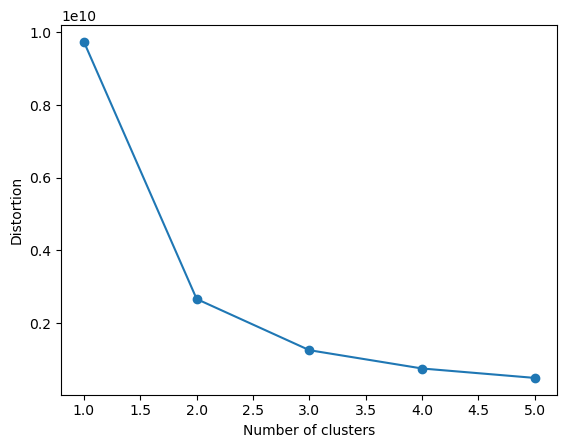

In [32]:
# 클러스터 2개가 최적
distortions = []

for i in range(1, 6):
    kmeans_i = KMeans(n_clusters=i, random_state=0) 
    kmeans_i.fit(X_features) 
    distortions.append(kmeans_i.inertia_) 
    
plt.plot(range(1,6), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [34]:
kmeans = KMeans(n_clusters=2, random_state=0)
Y_labels = kmeans.fit_predict(X_features)
print (Y_labels)

C:\Users\kchk0\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 0 0 ... 1 1 1]


In [35]:
df_whos['cluster'] = Y_labels

In [36]:
df_whos[df_whos['cluster'] == 0].position.unique()

array(['AMF,FW', 'FW', 'DF,MF', 'MF', 'MF,FW', 'DF', 'GK'], dtype=object)

In [37]:
# 클러스터 2개로 진행하여도 군집이 생성되는 기준이 보이지 않음
df_whos[df_whos['cluster'] == 1].position.unique()

array(['GK', 'FW', 'DF,MF', 'DF', 'AMF,FW', 'MF,FW', 'MF'], dtype=object)